## Polynomial Regression Model for Bitcoin Price Prediction

#### Summary of best model produced:
    polynomial degrees: 2
    features: 'ave_block_size', 'hash_rate', 'difficulty', 'block_height',
       'transaction_rate', 'exchange_balance', 'exchange_withdrawals',
       'exchange_deposits', 'miner_revenue', 'total_addresses',
       'daily_active_addresses', 'over_onebtc_addresses',
       'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo'
    R2: 0.663
    RMSE: 2546.6
    
These results are not good enough to pursue further

In [491]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import datetime as dt
import seaborn as sns

%matplotlib inline

### Create functions for use throughout the notebook

In [492]:
#create a function for producing initial insight into the dataframe

def initial_stats(df):
    print(df.head(), '\n')
    print('Number of missing values:\n', df.isna().sum(), '\n')
    print(df.shape, '\n')
    print(df.describe())
    rows_index = df.shape[0] - 1
    print('\nDate range is:', df.iloc[0,0], 'to', df.iloc[rows_index,0])
    

In [493]:
# create a list of the dataframes
df_list = []

# store the date value that is the soonest start date and the latest end date
date_range = []

# create a function for converting the timestamp to datetime and extracts date
def convert_timestamp(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df = df.drop(columns='timestamp')
    
    # find the soonest start date and latest end date
    start_date = min(df['date'])
    end_date = max(df['date'])
    if len(date_range) < 2:
        date_range.append(start_date)
        date_range.append(end_date)
    elif start_date > date_range[0]:
        date_range[0] = start_date
    elif end_date < date_range[1]:
        date_range[1] = end_date
        
    # append the list of dataframes
    df_list.append(df)
   
    return df

In [494]:
# create a function for adding a column of the one-day change values
# df is the dataframe to use, and col_val is the column index value

def add_change_col(df, col_val):
    df_up_one = df.iloc[1:, col_val]
    df_up = df_up_one.reset_index(drop=True)
    
    # get the percentage from one row to the next
    change_df = (df_up - df.iloc[:, col_val]) / df.iloc[:, col_val] * 100
    
    # fill in the first value with a dummy value of 0
    change_df = pd.concat([pd.Series([0]), change_df.iloc[:-1]])
    change_df = change_df.reset_index(drop=True)

    df['{}_change'.format(df.columns[col_val])] = change_df
    
    return df

## Price - Target Variable

In [495]:
# import price data and rough analysis
price = pd.read_csv(r'.\price.csv')
initial_stats(price)

              timestamp     value
0  2010-07-17T00:00:00Z  0.049510
1  2010-07-18T00:00:00Z  0.085840
2  2010-07-19T00:00:00Z  0.080800
3  2010-07-20T00:00:00Z  0.074733
4  2010-07-21T00:00:00Z  0.079210 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(3983, 2) 

              value
count   3983.000000
mean    4818.315246
std     9928.110057
min        0.049510
25%       85.049463
50%      581.290525
75%     6736.971907
max    63603.708172

Date range is: 2010-07-17T00:00:00Z to 2021-06-11T00:00:00Z


In [496]:
# convert the timestamp to datetime.date
price = convert_timestamp(price)

In [497]:
# rename the column from value to price
price.rename({'value' : 'price'}, axis=1, inplace=True)
price.head()

,price,date
0,0.049510,2010-07-17
1,0.085840,2010-07-18
2,0.080800,2010-07-19
3,0.074733,2010-07-20
4,0.079210,2010-07-21


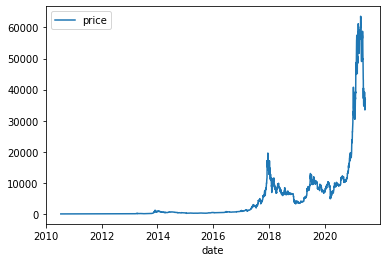

In [498]:
price.plot(kind='line', x='date', y='price')
plt.show()

In [499]:
# add a column that shows the daily change in price percentage
price = add_change_col(price, 0)

In [500]:
price.head()

,price,date,price_change
0,0.049510,2010-07-17,0.000000
1,0.085840,2010-07-18,73.379115
2,0.080800,2010-07-19,-5.871389
3,0.074733,2010-07-20,-7.508251
4,0.079210,2010-07-21,5.990187


In [501]:
price['price_change'].describe()

count    3983.000000
mean        0.487783
std         5.471416
min       -49.274119
25%        -1.355100
50%         0.198717
75%         2.088597
max        73.379115
Name: price_change, dtype: float64

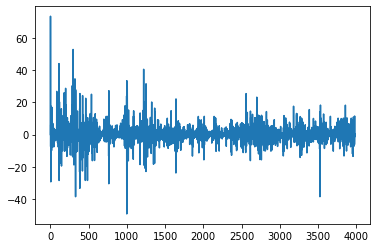

In [502]:
plt.plot(price['price_change'])

### Analysis of Target Variable- Price and Change in Price:
**Change in price** may be a better target for the prediction model. Because of the wide range of price values, even a small validation error may result in significant difference from the price value and predicted price value. Since the change of price percentage stays within a narrower range, the loss function may be a better indicator of the model's performance.

## Look at the future various prices

The primary problem in the field bitcoin price prediction is what the future price will be. By looking at current on-chain metrics, can the next day's price, or three days from now price be predicted. This can provide great knowledge for investors and allow them to plan they investing accordingly. By creating columns of various future prices, we can train the model to predict these values using current on-chain metrics.

#### Create values of price for next day, 7 days, 30 days, 90 days, and 180 days later.

In [503]:
one_day = price.iloc[1:, 0].reset_index().drop(columns='index').rename(columns={'price':'1_day'})
one_day_change = price.iloc[1:, 2].reset_index().drop(columns='index').rename(columns={'price_change':'1_day_change'})
three_day = price.iloc[3:, 0].reset_index().drop(columns='index').rename(columns={'price':'3_day'})
seven_day = price.iloc[6:, 0].reset_index().drop(columns='index').rename(columns={'price':'7_day'})
thirty_day = price.iloc[29:, 0].reset_index().drop(columns='index').rename(columns={'price':'30_day'})
ninety_day = price.iloc[89:, 0].reset_index().drop(columns='index').rename(columns={'price':'90_day'})
one_eighty_day = price.iloc[179:, 0].reset_index().drop(columns='index').rename(columns={'price':'180_day'})

In [504]:
one_day_change.head()

,1_day_change
0,73.379115
1,-5.871389
2,-7.508251
3,5.990187
4,-29.371292


In [505]:
one_day.tail()


,1_day
3977,33577.694225
3978,33452.002255
3979,37290.991776
3980,36744.739308
3981,36769.023139


In [506]:
one_day_change.tail()

,1_day_change
3977,-6.200804
3978,-0.374332
3979,11.476113
3980,-1.464838
3981,0.066088


In [507]:
price = pd.concat([price.iloc[:,:2], one_day_change, one_day, three_day, seven_day, thirty_day, ninety_day, one_eighty_day], axis=1)
price.head()

,price,date,1_day_change,1_day,3_day,7_day,30_day,90_day,180_day
0,0.049510,2010-07-17,73.379115,0.085840,0.074733,0.062283,0.06529,0.1020,0.31880
1,0.085840,2010-07-18,-5.871389,0.080800,0.079210,0.054540,0.06550,0.1050,0.31760
2,0.080800,2010-07-19,-7.508251,0.074733,0.055945,0.050500,0.07000,0.1010,0.40000
3,0.074733,2010-07-20,5.990187,0.079210,0.062283,0.056000,0.06800,0.1020,0.38600
4,0.079210,2010-07-21,-29.371292,0.055945,0.054540,0.059844,0.06670,0.1024,0.38679


# Features:

## Average Block Size

In [508]:
# import average block size data and rough analysis
ave_block_size = pd.read_csv(r'.\GlassNode_Data\block-size-mean.csv')
initial_stats(ave_block_size)

              timestamp       value
0  2009-01-09T00:00:00Z  215.000000
1  2009-01-10T00:00:00Z  215.229508
2  2009-01-11T00:00:00Z  215.408602
3  2009-01-12T00:00:00Z  234.372340
4  2009-01-13T00:00:00Z  215.666667 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4553, 2) 

              value
count  4.553000e+03
mean   5.210169e+05
std    4.715450e+05
min    2.150000e+02
25%    2.473093e+04
50%    3.934592e+05
75%    9.671785e+05
max    1.499183e+06

Date range is: 2009-01-09T00:00:00Z to 2021-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

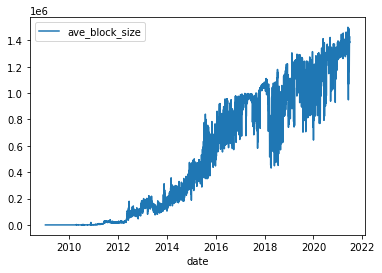

In [509]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
ave_block_size.rename({'value' : 'ave_block_size'}, axis=1, inplace=True)
ave_block_size = convert_timestamp(ave_block_size)
ave_block_size.plot(kind='line', x='date', y='ave_block_size')

## Hash Rate

In [510]:
# import hash rate data and rough analysis
hash_rate = pd.read_csv(r'.\GlassNode_Data\hash-rate.csv')
initial_stats(hash_rate)

              timestamp         value
0  2009-01-09T00:00:00Z  1.281850e+05
1  2009-01-10T00:00:00Z  1.676938e+06
2  2009-01-11T00:00:00Z  4.679436e+06
3  2009-01-12T00:00:00Z  4.653054e+06
4  2009-01-13T00:00:00Z  6.070590e+06 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4553, 2) 

              value
count  4.553000e+03
mean   2.443487e+19
std    4.469488e+19
min    1.281850e+05
25%    1.150495e+13
50%    3.306241e+17
75%    3.124441e+19
max    1.978909e+20

Date range is: 2009-01-09T00:00:00Z to 2021-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

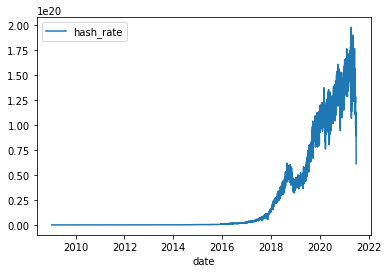

In [511]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
hash_rate.rename({'value':'hash_rate'}, axis=1, inplace=True)
hash_rate = convert_timestamp(hash_rate)
hash_rate.plot(kind='line', x='date', y='hash_rate')

## Difficulty

In [512]:
# import average block size data and rough analysis
difficulty = pd.read_csv(r'.\GlassNode_Data\difficulty.csv')
initial_stats(difficulty)

              timestamp         value
0  2009-01-09T00:00:00Z  4.294967e+09
1  2009-01-10T00:00:00Z  4.294967e+09
2  2009-01-11T00:00:00Z  4.294967e+09
3  2009-01-12T00:00:00Z  4.294967e+09
4  2009-01-13T00:00:00Z  4.294967e+09 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4553, 2) 

              value
count  4.553000e+03
mean   1.457148e+22
std    2.677179e+22
min    4.294967e+09
25%    6.833615e+15
50%    2.036998e+20
75%    1.779782e+22
max    1.075738e+23

Date range is: 2009-01-09T00:00:00Z to 2021-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

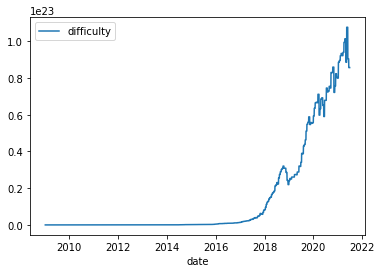

In [513]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
difficulty.rename({'value':'difficulty'}, axis=1, inplace=True)
difficulty = convert_timestamp(difficulty)
difficulty.plot(kind='line', x='date', y='difficulty')

## Block Height

In [514]:
# import average block height data and rough analysis
block_height = pd.read_csv(r'.\GlassNode_Data\block-height.csv')

<AxesSubplot:xlabel='date'>

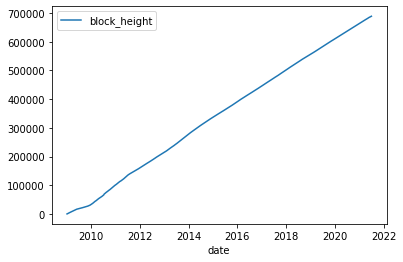

In [515]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
block_height.rename({'value':'block_height'}, axis=1, inplace=True)
block_height = convert_timestamp(block_height)
block_height.plot(kind='line', x='date', y='block_height')

## Transaction Rate

In [516]:
# import transaction rate data and rough analysis
transaction_rate = pd.read_csv(r'.\GlassNode_Data\transaction-rate.csv')
initial_stats(transaction_rate)

              timestamp  value
0  2009-01-03T00:00:00Z    0.0
1  2009-01-04T00:00:00Z    0.0
2  2009-01-05T00:00:00Z    0.0
3  2009-01-06T00:00:00Z    0.0
4  2009-01-07T00:00:00Z    0.0 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4559, 2) 

             value
count  4559.000000
mean      1.653451
std       1.476095
min       0.000000
25%       0.092130
50%       1.165127
75%       3.067442
max       5.676609

Date range is: 2009-01-03T00:00:00Z to 2021-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

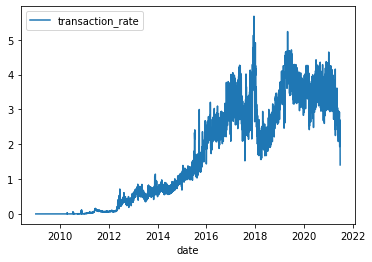

In [517]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
transaction_rate.rename({'value':'transaction_rate'}, axis=1, inplace=True)
transaction_rate = convert_timestamp(transaction_rate)
transaction_rate.plot(kind='line', x='date', y='transaction_rate')

In [518]:
# create 7 day moving average for the change in transaction rate
transaction_rate['7dMA_transaction_rate'] = transaction_rate['transaction_rate'].rolling(window=7).mean()
transaction_rate.head(14)

# create one-day change for transaction rate moving average
transaction_rate_df = add_change_col(transaction_rate, 2)

transaction_rate_df.head(14)


,transaction_rate,date,7dMA_transaction_rate,7dMA_transaction_rate_change
0,0.000000,2009-01-03,NaN,0.000000
1,0.000000,2009-01-04,NaN,NaN
2,0.000000,2009-01-05,NaN,NaN
3,0.000000,2009-01-06,NaN,NaN
4,0.000000,2009-01-07,NaN,NaN
5,0.000000,2009-01-08,NaN,NaN
6,0.000000,2009-01-09,0.000000,NaN
7,0.000000,2009-01-10,0.000000,NaN
8,0.000000,2009-01-11,0.000000,NaN
9,0.000081,2009-01-12,0.000012,inf


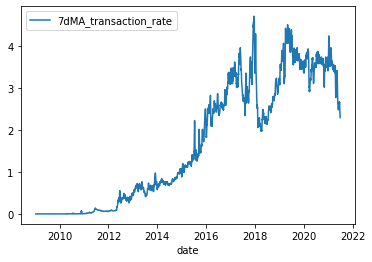

In [519]:
# plot the 20_day_MA of transaction rate
transaction_rate_df.plot(kind='line', x='date', y='7dMA_transaction_rate')
plt.show()

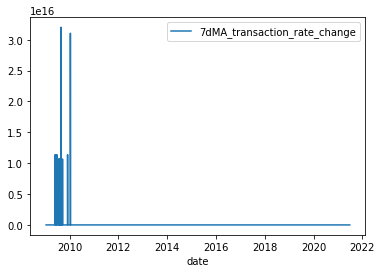

In [520]:
transaction_rate_df.plot(kind='line', x='date', y='7dMA_transaction_rate_change')
plt.show()

## Exchange Balance

In [521]:
# import exchange balance data and rough analysis
exchange_balance = pd.read_csv(r'.\GlassNode_Data\exchange-balance.csv')
initial_stats(exchange_balance)

              timestamp      value
0  2011-08-17T00:00:00Z   0.007500
1  2011-08-18T00:00:00Z   8.056529
2  2011-08-19T00:00:00Z  47.647947
3  2011-08-20T00:00:00Z  39.599918
4  2011-08-21T00:00:00Z  41.418918 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(3603, 2) 

              value
count  3.603000e+03
mean   1.302041e+06
std    1.087909e+06
min    7.500000e-03
25%    3.343947e+05
50%    9.835482e+05
75%    2.499679e+06
max    3.056155e+06

Date range is: 2011-08-17T00:00:00Z to 2021-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

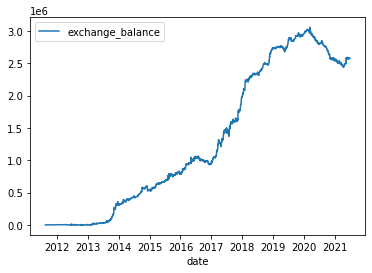

In [522]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
exchange_balance.rename({'value':'exchange_balance'}, axis=1, inplace=True)
exchange_balance = convert_timestamp(exchange_balance)
exchange_balance.plot(kind='line', x='date', y='exchange_balance')

## Exchange Withdrawals

In [523]:
# import exchange withdrawal and rough analysis
exchange_withdrawals = pd.read_csv(r'.\GlassNode_Data\exchange-withdrawals.csv')
initial_stats(exchange_withdrawals)

              timestamp  value
0  2011-08-17T00:00:00Z      0
1  2011-08-18T00:00:00Z      1
2  2011-08-19T00:00:00Z      0
3  2011-08-20T00:00:00Z      2
4  2011-08-21T00:00:00Z      0 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(3603, 2) 

               value
count    3603.000000
mean    21635.385512
std     20202.222225
min         0.000000
25%      2031.500000
50%     20436.000000
75%     35132.000000
max    107104.000000

Date range is: 2011-08-17T00:00:00Z to 2021-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

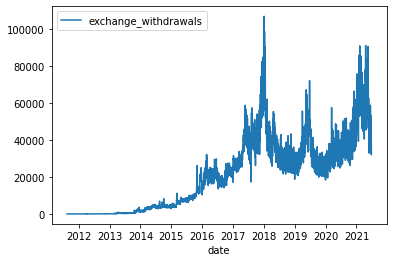

In [524]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
exchange_withdrawals.rename({'value':'exchange_withdrawals'}, axis=1, inplace=True)
exchange_withdrawals = convert_timestamp(exchange_withdrawals)
exchange_withdrawals.plot(kind='line', x='date', y='exchange_withdrawals')

## Exchange Deposits

In [525]:
# import exchange deposits data and rough analysis
exchange_deposits = pd.read_csv(r'.\GlassNode_Data\exchange-deposits.csv')
initial_stats(exchange_deposits)

              timestamp  value
0  2011-08-17T00:00:00Z      1
1  2011-08-18T00:00:00Z      3
2  2011-08-19T00:00:00Z      4
3  2011-08-20T00:00:00Z      1
4  2011-08-21T00:00:00Z      2 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(3603, 2) 

               value
count    3603.000000
mean    28309.417152
std     28705.293135
min         0.000000
25%      2992.000000
50%     25977.000000
75%     45152.000000
max    272008.000000

Date range is: 2011-08-17T00:00:00Z to 2021-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

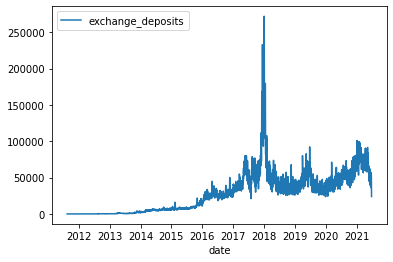

In [526]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
exchange_deposits.rename({'value':'exchange_deposits'}, axis=1, inplace=True)
exchange_deposits = convert_timestamp(exchange_deposits)
exchange_deposits.plot(kind='line', x='date', y='exchange_deposits')

## Miners Inflow Volume

In [527]:
# import miner inflow volume data and rough analysis
miner_inflow_vol = pd.read_csv(r'.\GlassNode_Data\miner-inflow-volume.csv')
initial_stats(miner_inflow_vol)

              timestamp  value
0  2009-01-03T00:00:00Z   50.0
1  2009-01-04T00:00:00Z    0.0
2  2009-01-05T00:00:00Z    0.0
3  2009-01-06T00:00:00Z    0.0
4  2009-01-07T00:00:00Z    0.0 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4194, 2) 

              value
count   4194.000000
mean    5532.124337
std     3975.044015
min        0.000000
25%     2415.495661
50%     4585.570653
75%     7603.450304
max    54968.693709

Date range is: 2009-01-03T00:00:00Z to 2020-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

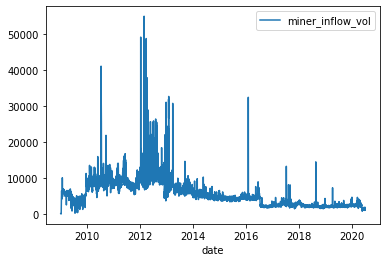

In [528]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
miner_inflow_vol.rename({'value':'miner_inflow_vol'}, axis=1, inplace=True)
miner_inflow_vol = convert_timestamp(miner_inflow_vol)
miner_inflow_vol.plot(kind='line', x='date', y='miner_inflow_vol')

## Miner Outflow Volume

In [529]:
# import miner outflow volume data and rough analysis
miner_outflow_vol = pd.read_csv(r'.\GlassNode_Data\miner-outflow-volume.csv')
initial_stats(miner_outflow_vol)

              timestamp  value
0  2009-01-03T00:00:00Z    0.0
1  2009-01-04T00:00:00Z    0.0
2  2009-01-05T00:00:00Z    0.0
3  2009-01-06T00:00:00Z    0.0
4  2009-01-07T00:00:00Z    0.0 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4194, 2) 

               value
count    4194.000000
mean     5098.490854
std      6331.576099
min         0.000000
25%      2051.547892
50%      3531.400796
75%      6998.152541
max    165845.314780

Date range is: 2009-01-03T00:00:00Z to 2020-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

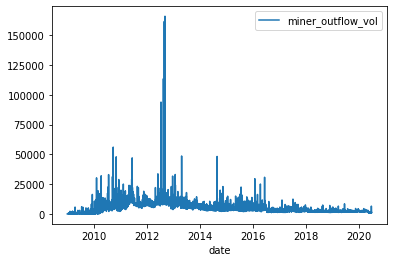

In [530]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
miner_outflow_vol.rename({'value':'miner_outflow_vol'}, axis=1, inplace=True)
miner_outflow_vol = convert_timestamp(miner_outflow_vol)
miner_outflow_vol.plot(kind='line', x='date', y='miner_outflow_vol')

## Miners Revenue

In [531]:
# import miner revenue data and rough analysis
miner_revenue = pd.read_csv(r'.\GlassNode_Data\miner-revenue-total.csv')
initial_stats(miner_revenue)

              timestamp  value
0  2009-01-03T00:00:00Z   50.0
1  2009-01-04T00:00:00Z    0.0
2  2009-01-05T00:00:00Z    0.0
3  2009-01-06T00:00:00Z    0.0
4  2009-01-07T00:00:00Z    0.0 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4559, 2) 

              value
count   4559.000000
mean    4166.443354
std     2838.558190
min        0.000000
25%     1958.139072
50%     3669.353087
75%     5750.000000
max    34600.000000

Date range is: 2009-01-03T00:00:00Z to 2021-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

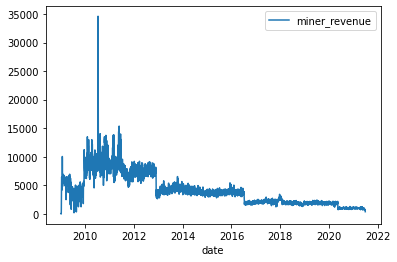

In [532]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
miner_revenue.rename({'value':'miner_revenue'}, axis=1, inplace=True)
miner_revenue = convert_timestamp(miner_revenue)
miner_revenue.plot(kind='line', x='date', y='miner_revenue')

## Miner Balance

In [533]:
# import miner balance data and rough analysis
miner_balance = pd.read_csv(r'.\GlassNode_Data\miner-balance.csv')
initial_stats(miner_balance)

              timestamp  value
0  2009-01-03T00:00:00Z   50.0
1  2009-01-04T00:00:00Z   50.0
2  2009-01-05T00:00:00Z   50.0
3  2009-01-06T00:00:00Z   50.0
4  2009-01-07T00:00:00Z   50.0 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4194, 2) 

              value
count  4.194000e+03
mean   1.924503e+06
std    4.335630e+05
min    5.000000e+01
25%    1.814936e+06
50%    1.942826e+06
75%    2.092134e+06
max    2.697960e+06

Date range is: 2009-01-03T00:00:00Z to 2020-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

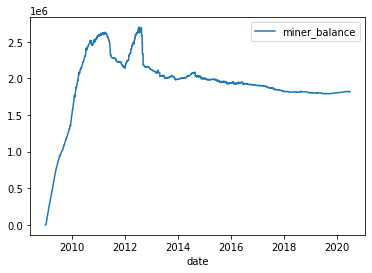

In [534]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
miner_balance.rename({'value':'miner_balance'}, axis=1, inplace=True)
miner_balance = convert_timestamp(miner_balance)
miner_balance.plot(kind='line', x='date', y='miner_balance')

###  It may be better if it only uses the September 2011 and newer data.

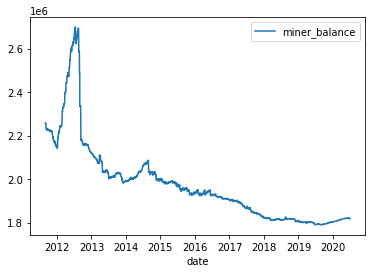

In [535]:
miner_balance[miner_balance['date'] > dt.date(2011, 9, 1)].plot(kind='line', x='date', y='miner_balance')
plt.show()


### This certainly looks more relevant and range bound. 1-1-2013 seems to be a better cut-off date, certainly for this set of data

## Miner to Exchange

In [536]:
# import miner_to_exchanges data and rough analysis
miner_to_exchanges = pd.read_csv(r'.\GlassNode_Data\miners-to-exchanges.csv')
initial_stats(miner_to_exchanges)

              timestamp     value
0  2011-08-18T00:00:00Z  7.082432
1  2011-08-19T00:00:00Z  0.000000
2  2011-08-20T00:00:00Z  0.000000
3  2011-08-21T00:00:00Z  0.000000
4  2011-08-22T00:00:00Z  0.000000 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(3237, 2) 

              value
count   3237.000000
mean     262.920725
std      608.411862
min        0.000000
25%       73.597261
50%      152.005978
75%      276.614734
max    17961.386845

Date range is: 2011-08-18T00:00:00Z to 2020-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

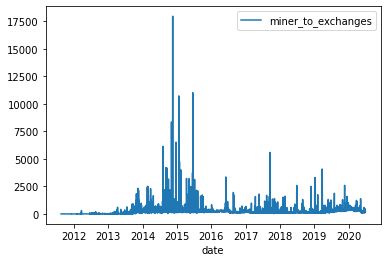

In [537]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
miner_to_exchanges.rename({'value':'miner_to_exchanges'}, axis=1, inplace=True)
miner_to_exchanges = convert_timestamp(miner_to_exchanges)
miner_to_exchanges.plot(kind='line', x='date', y='miner_to_exchanges')

## Total Addresses

In [538]:
# import total addresses and rough analysis
total_addresses = pd.read_csv(r'.\GlassNode_Data\total-addresses.csv')
initial_stats(total_addresses)

              timestamp  value
0  2009-01-03T00:00:00Z      1
1  2009-01-04T00:00:00Z      1
2  2009-01-05T00:00:00Z      1
3  2009-01-06T00:00:00Z      1
4  2009-01-07T00:00:00Z      1 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4559, 2) 

              value
count  4.559000e+03
mean   2.076464e+08
std    2.534553e+08
min    1.000000e+00
25%    3.076182e+06
50%    7.033741e+07
75%    3.967795e+08
max    8.468340e+08

Date range is: 2009-01-03T00:00:00Z to 2021-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

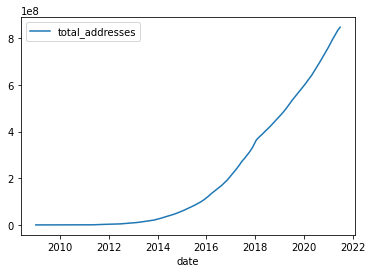

In [539]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
total_addresses.rename({'value':'total_addresses'}, axis=1, inplace=True)
total_addresses = convert_timestamp(total_addresses)
total_addresses.plot(kind='line', x='date', y='total_addresses')

## Daily Active Addresses

In [540]:
# import active addresses data and rough analysis
daily_active_addresses = pd.read_csv(r'.\GlassNode_Data\active-addresses.csv')
initial_stats(daily_active_addresses)

              timestamp  value
0  2009-01-03T00:00:00Z      0
1  2009-01-04T00:00:00Z      0
2  2009-01-05T00:00:00Z      0
3  2009-01-06T00:00:00Z      0
4  2009-01-07T00:00:00Z      0 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4559, 2) 

              value
count  4.559000e+03
mean   3.753300e+05
std    3.621253e+05
min    0.000000e+00
25%    1.961700e+04
50%    2.570070e+05
75%    6.786685e+05
max    1.362772e+06

Date range is: 2009-01-03T00:00:00Z to 2021-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

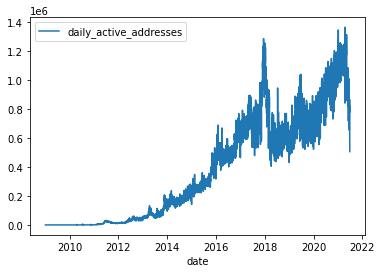

In [541]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
daily_active_addresses.rename({'value':'daily_active_addresses'}, axis=1, inplace=True)
daily_active_addresses = convert_timestamp(daily_active_addresses)
daily_active_addresses.plot(kind='line', x='date', y='daily_active_addresses')


## Balance of Addresses

### Addresses > 1 BTC

In [542]:
# import address data > 1 btc and rough analysis
over_onebtc_addresses = pd.read_csv(r'.\GlassNode_Data\addresses-with-balance-≥-1.csv')
initial_stats(over_onebtc_addresses)

              timestamp  value
0  2009-01-03T00:00:00Z      1
1  2009-01-04T00:00:00Z      1
2  2009-01-05T00:00:00Z      1
3  2009-01-06T00:00:00Z      1
4  2009-01-07T00:00:00Z      1 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4563, 2) 

               value
count    4563.000000
mean   398836.537804
std    285581.628114
min         1.000000
25%    125735.000000
50%    370736.000000
75%    704790.000000
max    830579.000000

Date range is: 2009-01-03T00:00:00Z to 2021-07-01T00:00:00Z


<AxesSubplot:xlabel='date'>

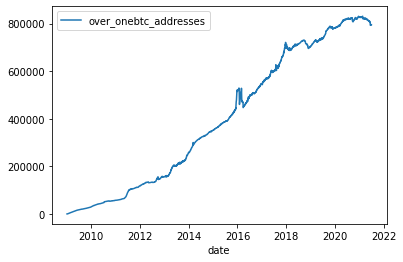

In [543]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
over_onebtc_addresses.rename({'value':'over_onebtc_addresses'}, axis=1, inplace=True)
over_onebtc_addresses = convert_timestamp(over_onebtc_addresses)
over_onebtc_addresses.plot(kind='line', x='date', y='over_onebtc_addresses')

### Addresses > 10 BTC

In [544]:
# import address data > 10 btc and rough analysis
over_tenbtc_addresses = pd.read_csv(r'.\GlassNode_Data\addresses-with-balance-≥-10.csv')
initial_stats(over_tenbtc_addresses)

              timestamp  value
0  2009-01-03T00:00:00Z      1
1  2009-01-04T00:00:00Z      1
2  2009-01-05T00:00:00Z      1
3  2009-01-06T00:00:00Z      1
4  2009-01-07T00:00:00Z      1 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4563, 2) 

               value
count    4563.000000
mean   108562.720359
std     45095.458054
min         1.000000
25%     74897.500000
50%    123389.000000
75%    149086.000000
max    157275.000000

Date range is: 2009-01-03T00:00:00Z to 2021-07-01T00:00:00Z


<AxesSubplot:xlabel='date'>

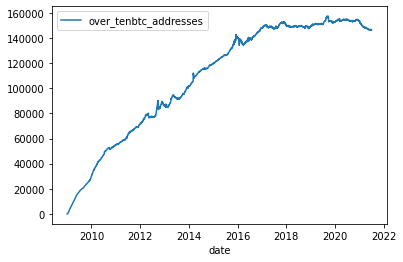

In [545]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
over_tenbtc_addresses.rename({'value':'over_tenbtc_addresses'}, axis=1, inplace=True)
over_tenbtc_addresses = convert_timestamp(over_tenbtc_addresses)
over_tenbtc_addresses.plot(kind='line', x='date', y='over_tenbtc_addresses')


### Addresses over 100 BTC

In [546]:
# import address data > 100 btc and rough analysis
over_onehunbtc_addresses = pd.read_csv(r'.\GlassNode_Data\addresses-with-balance-≥-100.csv')
initial_stats(over_onehunbtc_addresses)

              timestamp  value
0  2009-01-03T00:00:00Z      0
1  2009-01-04T00:00:00Z      0
2  2009-01-05T00:00:00Z      0
3  2009-01-06T00:00:00Z      0
4  2009-01-07T00:00:00Z      0 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4563, 2) 

              value
count   4563.000000
mean   11910.002411
std     6498.374129
min        0.000000
25%     7697.000000
50%    16001.000000
75%    16587.500000
max    18543.000000

Date range is: 2009-01-03T00:00:00Z to 2021-07-01T00:00:00Z


<AxesSubplot:xlabel='date'>

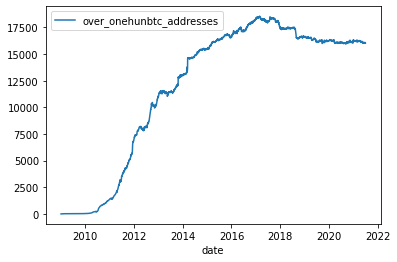

In [547]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
over_onehunbtc_addresses.rename({'value':'over_onehunbtc_addresses'}, axis=1, inplace=True)
over_onehunbtc_addresses = convert_timestamp(over_onehunbtc_addresses)
over_onehunbtc_addresses.plot(kind='line', x='date', y='over_onehunbtc_addresses')

## UTXO

In [548]:
# import UTXO data and rough analysis
utxo = pd.read_csv(r'.\GlassNode_Data\utx-os-total.csv')
initial_stats(utxo)

              timestamp  value
0  2009-01-03T00:00:00Z      1
1  2009-01-04T00:00:00Z      1
2  2009-01-05T00:00:00Z      1
3  2009-01-06T00:00:00Z      1
4  2009-01-07T00:00:00Z      1 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4559, 2) 

              value
count  4.559000e+03
mean   3.615384e+07
std    3.918749e+07
min    1.000000e+00
25%    1.337852e+06
50%    1.814996e+07
75%    5.701335e+07
max    1.252068e+08

Date range is: 2009-01-03T00:00:00Z to 2021-06-27T00:00:00Z


<AxesSubplot:xlabel='date'>

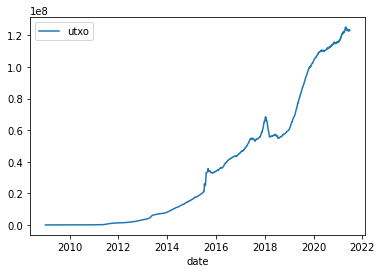

In [549]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
utxo.rename({'value':'utxo'}, axis=1, inplace=True)
utxo = convert_timestamp(utxo)
utxo.plot(kind='line', x='date', y='utxo')

# --------------------------------- New Features Added --------------------------------------

## SOPR

In [550]:
# import the sopr data
sopr = pd.read_csv(r'.\GlassNode_Data\sopr.csv')
initial_stats(sopr)

              timestamp     value
0  2010-07-17T00:00:00Z  1.000000
1  2010-07-18T00:00:00Z  1.174760
2  2010-07-19T00:00:00Z  1.318536
3  2010-07-20T00:00:00Z  1.090517
4  2010-07-21T00:00:00Z  1.065532 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(3982, 2) 

             value
count  3982.000000
mean      1.010183
std       0.047503
min       0.647491
25%       0.997017
50%       1.003105
75%       1.012456
max       1.896209

Date range is: 2010-07-17T00:00:00Z to 2021-06-10T00:00:00Z


<AxesSubplot:xlabel='date'>

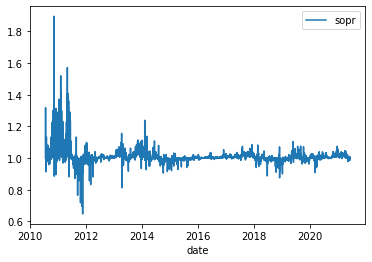

In [551]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
sopr.rename({'value':'sopr'}, axis=1, inplace=True)
sopr = convert_timestamp(sopr)
sopr.plot(kind='line', x='date', y='sopr')

## RHODL

In [552]:
# import rhodl data
rhodl = pd.read_csv(r'.\GlassNode_Data\rhodl-ratio.csv')
initial_stats(rhodl)

              timestamp     value
0  2010-08-17T00:00:00Z  0.202554
1  2010-08-18T00:00:00Z  0.388194
2  2010-08-19T00:00:00Z  0.581370
3  2010-08-20T00:00:00Z  0.735485
4  2010-08-21T00:00:00Z  0.965442 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(3951, 2) 

               value
count    3951.000000
mean     8885.391266
std     20411.471636
min         0.202554
25%       525.344392
50%      1853.958238
75%      8449.198447
max    219470.016332

Date range is: 2010-08-17T00:00:00Z to 2021-06-10T00:00:00Z


<AxesSubplot:xlabel='date'>

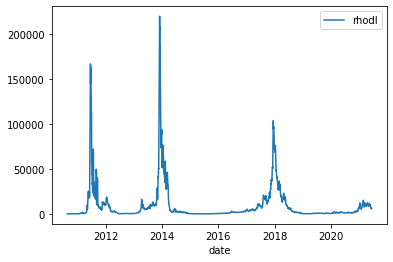

In [553]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
rhodl.rename({'value':'rhodl'}, axis=1, inplace=True)
rhodl = convert_timestamp(rhodl)
rhodl.plot(kind='line', x='date', y='rhodl')

## Reserve Risk

In [554]:
# import the reserve risk data
res_risk = pd.read_csv(r'.\GlassNode_Data\reserve-risk.csv')
initial_stats(res_risk)

              timestamp     value
0  2010-08-15T00:00:00Z  1.132036
1  2010-08-16T00:00:00Z  0.560768
2  2010-08-17T00:00:00Z  0.373186
3  2010-08-18T00:00:00Z  0.294741
4  2010-08-19T00:00:00Z  0.224639 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(3953, 2) 

             value
count  3953.000000
mean      0.007465
std       0.023692
min       0.000970
25%       0.001956
50%       0.003420
75%       0.007418
max       1.132036

Date range is: 2010-08-15T00:00:00Z to 2021-06-10T00:00:00Z


<AxesSubplot:xlabel='date'>

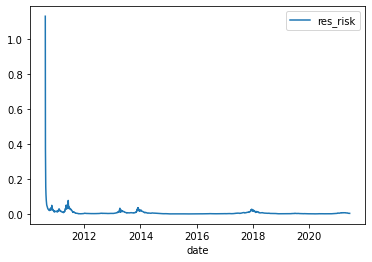

In [555]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
res_risk.rename({'value':'res_risk'}, axis=1, inplace=True)
res_risk = convert_timestamp(res_risk)
res_risk.plot(kind='line', x='date', y='res_risk')

<AxesSubplot:xlabel='date'>

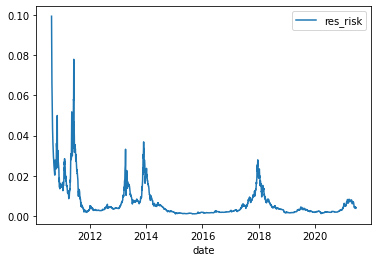

In [556]:
# view the plot without the massive spike in the beginning
rr_no_outliers = res_risk[res_risk['res_risk'] < 0.1]
rr_no_outliers.plot(kind='line', x='date', y='res_risk')

## Puell Multiple

In [557]:
# import the data
puell = pd.read_csv(r'.\GlassNode_Data\puell-multiple.csv')
initial_stats(puell)

              timestamp     value
0  2011-07-16T00:00:00Z  3.656330
1  2011-07-17T00:00:00Z  3.830945
2  2011-07-18T00:00:00Z  3.691357
3  2011-07-19T00:00:00Z  3.244558
4  2011-07-20T00:00:00Z  3.366804 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(3618, 2) 

             value
count  3618.000000
mean      1.477589
std       1.092461
min       0.283478
25%       0.745061
50%       1.173240
75%       1.862356
max      10.167732

Date range is: 2011-07-16T00:00:00Z to 2021-06-10T00:00:00Z


<AxesSubplot:xlabel='date'>

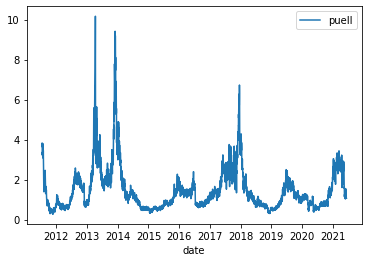

In [558]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
puell.rename({'value':'puell'}, axis=1, inplace=True)
puell = convert_timestamp(puell)
puell.plot(kind='line', x='date', y='puell')

## NVT Ratio

In [559]:
nvt = pd.read_csv(r'.\GlassNode_Data\nvt-ratio.csv')
initial_stats(nvt)

              timestamp       value
0  2010-07-18T00:00:00Z   95.861836
1  2010-07-19T00:00:00Z   73.314284
2  2010-07-20T00:00:00Z  115.888962
3  2010-07-21T00:00:00Z  125.705527
4  2010-07-22T00:00:00Z   87.922220 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(3981, 2) 

             value
count  3981.000000
mean     24.009796
std      26.190820
min       0.224882
25%      10.391571
50%      18.529059
75%      29.717838
max     448.150102

Date range is: 2010-07-18T00:00:00Z to 2021-06-10T00:00:00Z


<AxesSubplot:xlabel='date'>

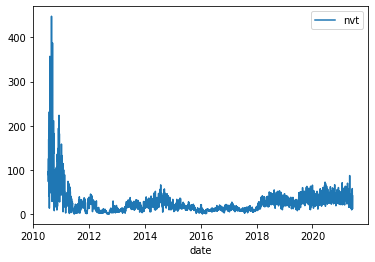

In [560]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
nvt.rename({'value':'nvt'}, axis=1, inplace=True)
nvt = convert_timestamp(nvt)
nvt.plot(kind='line', x='date', y='nvt')

## NUPL

In [561]:
# import the nupl data
nupl = pd.read_csv(r'.\GlassNode_Data\nupl.csv')
initial_stats(nupl)

              timestamp     value
0  2010-07-18T00:00:00Z  0.421756
1  2010-07-19T00:00:00Z  0.380821
2  2010-07-20T00:00:00Z  0.328775
3  2010-07-21T00:00:00Z  0.365481
4  2010-07-22T00:00:00Z  0.102038 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(3981, 2) 

             value
count  3981.000000
mean      0.331661
std       0.318370
min      -1.556947
25%       0.195707
50%       0.404822
75%       0.553495
max       0.877967

Date range is: 2010-07-18T00:00:00Z to 2021-06-10T00:00:00Z


<AxesSubplot:xlabel='date'>

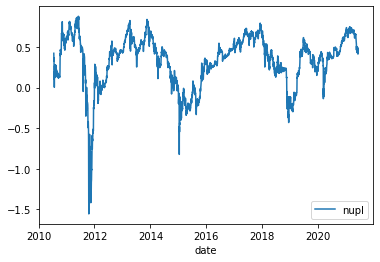

In [562]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
nupl.rename({'value':'nupl'}, axis=1, inplace=True)
nupl = convert_timestamp(nupl)
nupl.plot(kind='line', x='date', y='nupl')

## MVRV Ratio

In [563]:
mvrv_ratio = pd.read_csv(r'.\GlassNode_Data\mvrv-ratio.csv')
initial_stats(mvrv_ratio)

              timestamp     value
0  2010-07-17T00:00:00Z  1.000000
1  2010-07-18T00:00:00Z  1.300600
2  2010-07-19T00:00:00Z  1.814750
3  2010-07-20T00:00:00Z  1.586253
4  2010-07-21T00:00:00Z  1.399411 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(3982, 2) 

             value
count  3982.000000
mean      1.842166
std       0.892532
min       0.399227
25%       1.248235
50%       1.674141
75%       2.233915
max       7.120453

Date range is: 2010-07-17T00:00:00Z to 2021-06-10T00:00:00Z


<AxesSubplot:xlabel='date'>

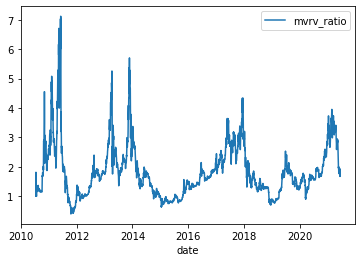

In [564]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
mvrv_ratio.rename({'value':'mvrv_ratio'}, axis=1, inplace=True)
mvrv_ratio = convert_timestamp(mvrv_ratio)
mvrv_ratio.plot(kind='line', x='date', y='mvrv_ratio')

## MVRV Z-score

In [565]:
# import data for mvrv z-score
mvrv_z = pd.read_csv(r'.\GlassNode_Data\mvrv-z-score.csv')
initial_stats(mvrv_z)

              timestamp     value
0  2010-07-18T00:00:00Z  2.518053
1  2010-07-19T00:00:00Z  2.097027
2  2010-07-20T00:00:00Z  1.651545
3  2010-07-21T00:00:00Z  1.927019
4  2010-07-22T00:00:00Z  0.885502 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(3981, 2) 

             value
count  3981.000000
mean      1.698312
std       1.911428
min      -0.830057
25%       0.459079
50%       1.208088
75%       2.320322
max      12.547296

Date range is: 2010-07-18T00:00:00Z to 2021-06-10T00:00:00Z


<AxesSubplot:xlabel='date'>

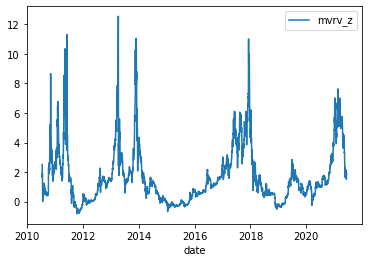

In [566]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
mvrv_z.rename({'value':'mvrv_z'}, axis=1, inplace=True)
mvrv_z = convert_timestamp(mvrv_z)
mvrv_z.plot(kind='line', x='date', y='mvrv_z')

## CVDD

In [567]:
# import the cvdd data
cvdd = pd.read_csv(r'.\GlassNode_Data\cvdd.csv')
initial_stats(cvdd)

              timestamp         value
0  2010-07-17T00:00:00Z  9.583721e-09
1  2010-07-18T00:00:00Z  2.880765e-05
2  2010-07-19T00:00:00Z  4.023622e-05
3  2010-07-20T00:00:00Z  4.209650e-05
4  2010-07-21T00:00:00Z  6.109906e-05 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(3982, 2) 

              value
count  3.982000e+03
mean   1.344208e+03
std    2.007571e+03
min    9.583721e-09
25%    6.929988e+00
50%    1.694949e+02
75%    2.657301e+03
max    9.546828e+03

Date range is: 2010-07-17T00:00:00Z to 2021-06-10T00:00:00Z


<AxesSubplot:xlabel='date'>

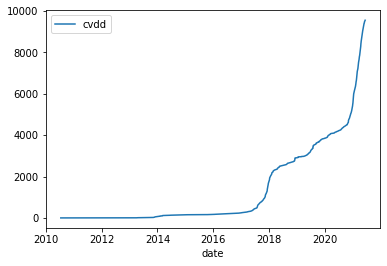

In [568]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
cvdd.rename({'value':'cvdd'}, axis=1, inplace=True)
cvdd = convert_timestamp(cvdd)
cvdd.plot(kind='line', x='date', y='cvdd')

## CYD

In [569]:
# import the data for cyd
cyd = pd.read_csv(r'.\GlassNode_Data\cyd.csv')
initial_stats(cyd)

              timestamp         value
0  2010-01-11T00:00:00Z  3.461755e+06
1  2010-01-12T00:00:00Z  3.943371e+06
2  2010-01-13T00:00:00Z  3.943582e+06
3  2010-01-14T00:00:00Z  3.949321e+06
4  2010-01-15T00:00:00Z  3.949512e+06 

Number of missing values:
 timestamp    0
value        0
dtype: int64 

(4169, 2) 

              value
count  4.169000e+03
mean   2.521463e+09
std    1.578675e+09
min    3.461755e+06
25%    1.281882e+09
50%    2.459569e+09
75%    3.487977e+09
max    6.728864e+09

Date range is: 2010-01-11T00:00:00Z to 2021-06-10T00:00:00Z


<AxesSubplot:xlabel='date'>

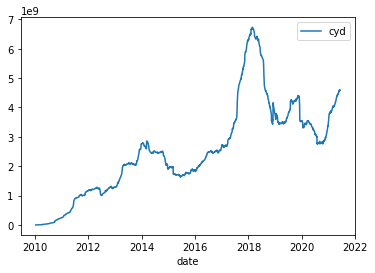

In [570]:
# change the name of the column, adjust timestamp to datatime.date format, plot the data
cyd.rename({'value':'cyd'}, axis=1, inplace=True)
cyd = convert_timestamp(cyd)
cyd.plot(kind='line', x='date', y='cyd')

## Check the list of df names and remove the miner data that does not have data past 2020

Dataframes miner_inflow_vol, miner_outflow_vol, miner_balance, miner_to_exchanges only have data up to date 06-27-2020 and therefor are missing relevant recent data. These dataframes will be dropped and not used in the model.

In [571]:
# view the name of the different dataframes in the full list of dataframes aggregated
df_names_list = [df.columns[0] for df in df_list]
print(df_names_list)

['price', 'ave_block_size', 'hash_rate', 'difficulty', 'block_height', 'transaction_rate', 'exchange_balance', 'exchange_withdrawals', 'exchange_deposits', 'miner_inflow_vol', 'miner_outflow_vol', 'miner_revenue', 'miner_balance', 'miner_to_exchanges', 'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses', 'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo', 'sopr', 'rhodl', 'res_risk', 'puell', 'nvt', 'nupl', 'mvrv_ratio', 'mvrv_z', 'cvdd', 'cyd']


In [572]:
# drop miner names from list, except for miner_revenue
drop_list = ['miner_inflow_vol', 'miner_outflow_vol', 'miner_balance', 'miner_to_exchanges']

# create a new list of df without the drop_list dfs
df_new_list = []

for df in df_list:
    if df.columns[0] not in drop_list:
        df_new_list.append(df)
        
[df.columns[0] for df in df_new_list]

['price',
 'ave_block_size',
 'hash_rate',
 'difficulty',
 'block_height',
 'transaction_rate',
 'exchange_balance',
 'exchange_withdrawals',
 'exchange_deposits',
 'miner_revenue',
 'total_addresses',
 'daily_active_addresses',
 'over_onebtc_addresses',
 'over_tenbtc_addresses',
 'over_onehunbtc_addresses',
 'utxo',
 'sopr',
 'rhodl',
 'res_risk',
 'puell',
 'nvt',
 'nupl',
 'mvrv_ratio',
 'mvrv_z',
 'cvdd',
 'cyd']

### Date Range to use for combining the data

Based on the exploratory data analysis. The date range looks like it should start at January of 2012 and go to current.

### Create single dataframe joined on the date column with only the data between 01-01-2012 and 06-11-2021

Since I will not be including most of the miner data, I can now use up to 6-11-2021 which is the price date range end

In [573]:
# create the final df using the price df and merge the rest and have price be the last column
def date_bool(df):
    return df[(df['date'] >= dt.date(2013, 1, 1)) & (df['date'] <= dt.date(2021, 6, 11))]
                                              
# create a new df with the various price targets in the new date range
btc_final = date_bool(price)

# loop through the df list and add them to the btc_final df
for df in df_new_list[1:]:
    df = date_bool(df)
    btc_final = pd.merge(btc_final, df, on='date', how='inner')

In [574]:
btc_final.head()

,price,date,1_day_change,1_day,3_day,7_day,30_day,90_day,180_day,ave_block_size,...,sopr,rhodl,res_risk,puell,nvt,nupl,mvrv_ratio,mvrv_z,cvdd,cyd
0,13.220,2013-01-01,-1.406959,13.034,13.174,13.20,19.450000,96.149146,88.980000,89114.771605,...,0.998396,439.530560,0.003676,0.930871,7.582447,0.433613,1.760238,1.419095,2.378916,1.292381e+09
1,13.034,2013-01-02,1.196870,13.190,13.150,13.50,20.460000,104.706000,89.483037,114158.385621,...,0.999711,448.670542,0.003656,0.876133,5.886555,0.427886,1.754977,1.367144,2.380707,1.292639e+09
2,13.190,2013-01-03,-0.121304,13.174,13.150,13.58,20.363143,115.803182,83.866380,108105.271605,...,1.000494,457.846890,0.003648,0.927063,6.719452,0.428949,1.755247,1.405822,2.382824,1.293475e+09
3,13.174,2013-01-04,-0.182177,13.150,13.200,14.00,19.821210,132.545678,87.920276,141893.150327,...,1.002167,484.577915,0.003648,0.877796,4.761873,0.431352,1.758160,1.392039,2.388469,1.294278e+09
4,13.150,2013-01-05,0.000000,13.150,13.500,14.00,20.296000,134.940325,77.870028,118321.985816,...,1.000162,479.252069,0.003624,0.806903,5.219117,0.428056,1.751028,1.389545,2.389654,1.293662e+09


In [575]:
btc_final.tail()

,price,date,1_day_change,1_day,3_day,7_day,30_day,90_day,180_day,ave_block_size,...,sopr,rhodl,res_risk,puell,nvt,nupl,mvrv_ratio,mvrv_z,cvdd,cyd
3078,35797.422390,2021-06-06,-6.200804,33577.694225,37290.991776,NaN,NaN,NaN,NaN,9.487188e+05,...,0.997157,6321.039616,0.004052,1.331192,18.789687,0.448284,1.821857,1.755588,9506.650647,4.582211e+09
3079,33577.694225,2021-06-07,-0.374332,33452.002255,36744.739308,NaN,NaN,NaN,NaN,1.250725e+06,...,0.995403,6405.737674,0.004038,1.175687,15.038428,0.412358,1.820145,1.513266,9515.294909,4.587852e+09
3080,33452.002255,2021-06-08,11.476113,37290.991776,36769.023139,NaN,NaN,NaN,NaN,1.286349e+06,...,0.984001,5921.590867,0.003695,1.200712,11.643820,0.412283,1.673709,1.505933,9527.181847,4.584950e+09
3081,37290.991776,2021-06-09,-1.464838,36744.739308,NaN,NaN,NaN,NaN,NaN,1.067569e+06,...,1.010583,5996.075969,0.003912,1.065361,31.230868,0.472070,1.772281,1.929253,9535.152630,4.586718e+09
3082,36744.739308,2021-06-10,0.066088,36769.023139,NaN,NaN,NaN,NaN,NaN,1.311452e+06,...,1.002085,5811.843658,0.004143,1.068601,41.055235,0.464044,1.879714,1.858199,9546.828061,4.587959e+09


In [432]:
btc_final.columns

Index(['price', 'date', '1_day_change', '1_day', '3_day', '7_day', '30_day',
       '90_day', '180_day', 'ave_block_size', 'hash_rate', 'difficulty',
       'block_height', 'transaction_rate', '7dMA_transaction_rate',
       '7dMA_transaction_rate_change', 'exchange_balance',
       'exchange_withdrawals', 'exchange_deposits', 'miner_revenue',
       'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses',
       'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo', 'sopr',
       'rhodl', 'res_risk', 'puell', 'nvt', 'nupl', 'mvrv_ratio', 'mvrv_z',
       'cvdd', 'cyd'],
      dtype='object')

### Create new dataframes for the various different predictions.

Create a new dataframe for the target 1_day, 7_day, 30_day, 90_day, and 180_day. This will allow features to be revealed that are specific for short term prediction as well as the features that are specific for the long term predictions. 

In [433]:
# create a function to process the dataframe and create desired new ones
def create_dataframe(df, col_name):
    date_df = df[['date']]
    target = df[[col_name]]
    column_names = ['ave_block_size', 'hash_rate', 'difficulty', 'block_height', 'transaction_rate', 'exchange_balance', 
                    'exchange_withdrawals', 'exchange_deposits', 'miner_revenue', 'total_addresses', 'daily_active_addresses',
                   'over_onebtc_addresses', 'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo', 'price']
    features = df.loc[:, column_names]
    new_df = pd.concat([date_df, features, target], axis=1)
    return new_df
    

In [434]:
# create the new dataframes with the specific targets of interest and remove the data that is out of the prediction range

df_1_day = create_dataframe(btc_final.iloc[:-1, :], '1_day')
df_3_day = create_dataframe(btc_final.iloc[:-3, :], '3_day')
df_7_day = create_dataframe(btc_final.iloc[:-7, :], '7_day')
df_30_day = create_dataframe(btc_final.iloc[:-30, :], '30_day')
df_90_day = create_dataframe(btc_final.iloc[:-90, :], '90_day')
df_180_day = create_dataframe(btc_final.iloc[:-180, :], '180_day')
df_1_day_change = create_dataframe(btc_final.iloc[:-1, :], '1_day_change')




In [435]:
df_180_day.tail()

,date,ave_block_size,hash_rate,difficulty,block_height,transaction_rate,exchange_balance,exchange_withdrawals,exchange_deposits,miner_revenue,total_addresses,daily_active_addresses,over_onebtc_addresses,over_tenbtc_addresses,over_onehunbtc_addresses,utxo,price,180_day
2898,2020-12-08,1.286538e+06,1.373915e+20,8.227935e+22,660556,3.829005,2.560723e+06,45812,60876,972.190482,747779329,1060847,823584,153990,16119,115227051,18327.694818,35533.746588
2899,2020-12-09,1.275818e+06,1.323202e+20,8.227935e+22,660695,3.714583,2.553090e+06,47901,61778,941.207294,748309692,1058484,824225,153996,16135,115338499,18564.904366,35797.422390
2900,2020-12-10,1.306711e+06,1.239075e+20,8.227935e+22,660825,3.628692,2.547062e+06,50015,57602,885.332869,748822558,993039,825050,154177,16125,115462581,18272.716244,33577.694225
2901,2020-12-11,1.325937e+06,1.320266e+20,8.227935e+22,660963,3.525428,2.552486e+06,46887,59922,932.996300,749330847,1075098,825602,154275,16120,115504066,18079.312133,33452.002255
2902,2020-12-12,1.296116e+06,1.273510e+20,8.227935e+22,661095,3.417569,2.557838e+06,42219,53653,875.588359,749813135,963457,826043,154300,16114,115531445,18799.924438,37290.991776


In [436]:
df_1_day_change.tail()

,date,ave_block_size,hash_rate,difficulty,block_height,transaction_rate,exchange_balance,exchange_withdrawals,exchange_deposits,miner_revenue,total_addresses,daily_active_addresses,over_onebtc_addresses,over_tenbtc_addresses,over_onehunbtc_addresses,utxo,price,1_day_change
3077,2021-06-05,1.083917e+06,1.374711e+20,9.039931e+22,686435,2.250567,2.579840e+06,38637,45105,848.390854,838825932,772676,808581,146353,16048,123011623,35533.746588,0.742043
3078,2021-06-06,9.487188e+05,1.567872e+20,9.039931e+22,686585,2.142998,2.580070e+06,33378,39821,960.078926,839134321,715945,808124,146322,16053,122948229,35797.422390,-6.200804
3079,2021-06-07,1.250725e+06,1.391161e+20,9.039931e+22,686718,2.723912,2.575684e+06,47350,55663,865.806271,839539074,907287,804696,146239,16070,122937997,33577.694225,-0.374332
3080,2021-06-08,1.286349e+06,1.556879e+20,9.039931e+22,686867,2.855984,2.571881e+06,55598,59802,966.497220,839961397,1002115,804479,146216,16072,122886946,33452.002255,11.476113
3081,2021-06-09,1.067569e+06,1.325858e+20,9.039931e+22,686993,2.439641,2.563289e+06,53364,50795,820.838852,840332902,815580,805686,146421,16094,123024545,37290.991776,-1.464838


In [437]:
df_1_day.head()

,date,ave_block_size,hash_rate,difficulty,block_height,transaction_rate,exchange_balance,exchange_withdrawals,exchange_deposits,miner_revenue,total_addresses,daily_active_addresses,over_onebtc_addresses,over_tenbtc_addresses,over_onehunbtc_addresses,utxo,price,1_day
0,2013-01-01,89114.771605,2.351004e+13,1.279744e+16,214724,0.367292,2575.409335,43,200,4075.405018,8727440,37576,156337,86298,11066,3247297,13.220,13.034
1,2013-01-02,114158.385621,2.245758e+13,1.279744e+16,214877,0.454630,3184.319144,60,229,3857.067089,8751648,42904,156611,86425,11024,3262506,13.034,13.190
2,2013-01-03,108105.271605,2.370005e+13,1.279744e+16,215039,0.487812,2830.291416,53,198,4087.663327,8781926,51040,156731,86486,11055,3277036,13.190,13.174
3,2013-01-04,141893.150327,2.217074e+13,1.279744e+16,215192,0.560602,2819.834982,72,373,3863.499613,8807659,47120,156603,86309,11098,3287340,13.174,13.150
4,2013-01-05,118321.985816,2.060638e+13,1.279744e+16,215333,0.456655,3527.843016,53,305,3556.348094,8835133,53310,156384,85970,11147,3303604,13.150,13.150


## Prepare Data For Prediction Model

### Normalize the features of the dataframe using MinMaxScaler

This uses the following formula to create the data values to between 0 and 1:
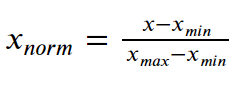

In [438]:
df_1_day.head()

,date,ave_block_size,hash_rate,difficulty,block_height,transaction_rate,exchange_balance,exchange_withdrawals,exchange_deposits,miner_revenue,total_addresses,daily_active_addresses,over_onebtc_addresses,over_tenbtc_addresses,over_onehunbtc_addresses,utxo,price,1_day
0,2013-01-01,89114.771605,2.351004e+13,1.279744e+16,214724,0.367292,2575.409335,43,200,4075.405018,8727440,37576,156337,86298,11066,3247297,13.220,13.034
1,2013-01-02,114158.385621,2.245758e+13,1.279744e+16,214877,0.454630,3184.319144,60,229,3857.067089,8751648,42904,156611,86425,11024,3262506,13.034,13.190
2,2013-01-03,108105.271605,2.370005e+13,1.279744e+16,215039,0.487812,2830.291416,53,198,4087.663327,8781926,51040,156731,86486,11055,3277036,13.190,13.174
3,2013-01-04,141893.150327,2.217074e+13,1.279744e+16,215192,0.560602,2819.834982,72,373,3863.499613,8807659,47120,156603,86309,11098,3287340,13.174,13.150
4,2013-01-05,118321.985816,2.060638e+13,1.279744e+16,215333,0.456655,3527.843016,53,305,3556.348094,8835133,53310,156384,85970,11147,3303604,13.150,13.150


In [439]:
# set the index to be the date
df_1_day.set_index('date', inplace=True)

In [440]:
from sklearn.preprocessing import MinMaxScaler

# create the min max scaler object
scaler = MinMaxScaler()

# all the columns except the last one of price
cols = df_1_day.columns[:-2]

# normalize the features
feat_1_day = pd.DataFrame(scaler.fit_transform(df_1_day.iloc[:, :-2]),
              columns=cols, index=df_1_day.index) 

feat_1_day.head()

,ave_block_size,hash_rate,difficulty,block_height,transaction_rate,exchange_balance,exchange_withdrawals,exchange_deposits,miner_revenue,total_addresses,daily_active_addresses,over_onebtc_addresses,over_tenbtc_addresses,over_onehunbtc_addresses,utxo
date,,,,,,,,,,,,,,,
2013-01-01,0.009112,2.867282e-08,4.336451e-10,0.000000,0.003398,0.000731,0.000075,0.000140,0.578680,0.000000,0.000000,0.001460,0.020764,0.005586,0.000000
2013-01-02,0.026710,2.335443e-08,4.336451e-10,0.000324,0.019792,0.000930,0.000233,0.000246,0.541335,0.000029,0.004021,0.001866,0.022516,0.000000,0.000125
2013-01-03,0.022457,2.963301e-08,4.336451e-10,0.000667,0.026021,0.000814,0.000168,0.000132,0.580777,0.000066,0.010160,0.002044,0.023358,0.004123,0.000244
2013-01-04,0.046200,2.190495e-08,4.336451e-10,0.000991,0.039684,0.000811,0.000346,0.000776,0.542435,0.000096,0.007202,0.001854,0.020916,0.009842,0.000328
2013-01-05,0.029636,1.399982e-08,4.336451e-10,0.001290,0.020172,0.001042,0.000168,0.000526,0.489899,0.000130,0.011873,0.001530,0.016239,0.016359,0.000462


## Function for training and testing Polynomial Regression models efficiently

This function takes as input an unstandardized dataframe. The user defines the list of features and the target. Print_out allows the user to see all of the metrics for every polynomial degree tested. If you only want to see the metrics from the best performing polynomial, then keep print_out=False.

The function standardizes the dataframe data. Then creates a holdout set, as well as, training and testing sets. The function then loops through degrees 2 to 5 using that for different polynomial models. The polynomial model is trained and tested. The polynomial model with the highest test set R-squared value is deemed the best. That degree polynomial is then used on the holdout set and a plot of the predicted vs the actual is returned, as well as the RMSE and R-squared values.

In [441]:
from sklearn.preprocessing import MinMaxScaler

def matrix_poly_regression(df, features, target, print_out=False):
    
    ''' 
        df is the raw dataframe
        features is the names of the features to use
        target is the name of the target value or y value
        print_out=False returns only the statistics for the best performing model
    '''

    # create the min max scaler object
    scaler = MinMaxScaler()
    
    # create df of the target and current price with the date
    target = df[[target, 'price', 'date']]
    
    # create the features and the date
    feat = df[features]
    
    # normalize the features
    feat_df = pd.DataFrame(scaler.fit_transform(feat),
              columns=feat.columns, index=feat.index) 

    # remove some data to be used as holdout set
    X_holdout = feat_df.iloc[-30:, :]
    y_holdout = target.iloc[-30:, :]
    
    # create a df of all but the final 30 days
    X = feat_df.iloc[:-30 , :]
    y = target.iloc[:-30, 0]
    
    # split the data to train and test groups
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

        
    # run the polynomial regression on the training and testing data
    # and store the best degree polynomial degree
    max_deg = polynomial_reg(X_train, X_test, y_train, y_test, 2, 5, print_out=print_out)
    
    # create polynomial model and train model
    polynomial_features = PolynomialFeatures(degree = max_deg)
    X_TRANSF = polynomial_features.fit_transform(X_train)
    model = LinearRegression()
    model.fit(X_TRANSF, y_train)

    # use model to predict target
    predict_poly = polynomial_features.fit_transform(X_holdout)    

    y_pred_final = model.predict(predict_poly)
    
    # create a dataframe with only the final 30 days of the 1_day data
    y_holdout_final = pd.DataFrame(y_holdout)
    
    # create a column with the predicted 1_day price
    y_holdout_final['pred_1_day'] = y_pred_final
    
    # create a new column with the previous 1_day prediction to be used for creating a change of prediction value
    y_holdout_final['prev_pred_1_day'] = y_holdout_final['pred_1_day'].shift(1)
    
    # find the change between the previous days 1_day prediction and the current days 1 day prediction
    change = (y_holdout_final['pred_1_day'] - y_holdout_final['prev_pred_1_day']) / y_holdout_final['prev_pred_1_day']

    # adjust the current price based on the predicted prices difference and use that as the new prediction
    y_holdout_final['new_pred'] = y_holdout_final['price'] * (1 + change)
    
    # remove the first and last row with NaN
    y_holdout_final = y_holdout_final.dropna()
    
    # plot the values for the predicted and the actual 1 day price
    fig, ax = plt.subplots()

    ax.plot(y_holdout_final.index, y_holdout_final['1_day'], label='actual')
    ax.plot(y_holdout_final.index, y_holdout_final['new_pred'], label='predicted')
    plt.legend()
    plt.xticks(rotation='vertical')
    plt.show()

    print('The results for Polynomial Regression using these features:\n', features)
    
    mse = mean_squared_error(y_holdout_final['1_day'], y_holdout_final['new_pred'])
    rmse = np.sqrt(mse)
    print('30-day holdout RMSE:', rmse)
    
    r2 = r2_score(y_holdout_final['1_day'], y_holdout_final['new_pred'])
    print('30-day holdout: R2:', r2)
    print('\n\n\n\n')

    # return the R-squared for the 30-day holdout for performance comparison
    return r2
    



    

## Linear Regression Model for 1 Day Price

### Run a polynomial regression model on the normalized features and the 1 day price

### ---------Remove out bottom 30 days worth of data and use for final validation prediction-----------------------

In [442]:
# create a small dataframe of 30 values to exclude that will act as the prediction test
X_final_test = feat_1_day.iloc[-30:, :]
y_final_test = df_1_day.iloc[-30:, -1]

In [443]:
X_final_test.tail()

,ave_block_size,hash_rate,difficulty,block_height,transaction_rate,exchange_balance,exchange_withdrawals,exchange_deposits,miner_revenue,total_addresses,daily_active_addresses,over_onebtc_addresses,over_tenbtc_addresses,over_onehunbtc_addresses,utxo
date,,,,,,,,,,,,,,,
2021-06-05,0.708183,0.694681,0.840347,0.998818,0.356904,0.844128,0.360534,0.165325,0.026721,0.998188,0.554710,0.967421,0.849314,0.668174,0.982001
2021-06-06,0.613176,0.792291,0.840347,0.999136,0.336712,0.844203,0.311416,0.145888,0.045825,0.998559,0.511901,0.966745,0.848887,0.668839,0.981481
2021-06-07,0.825402,0.702994,0.840347,0.999418,0.445755,0.842768,0.441911,0.204163,0.029700,0.999045,0.656289,0.961668,0.847742,0.671100,0.981397
2021-06-08,0.850436,0.786736,0.840347,0.999733,0.470546,0.841524,0.518946,0.219389,0.046923,0.999553,0.727846,0.961346,0.847424,0.671366,0.980979
2021-06-09,0.696695,0.669994,0.840347,1.000000,0.392395,0.838712,0.498081,0.186256,0.022009,1.000000,0.587086,0.963134,0.850252,0.674292,0.982107


In [444]:
# create separate arrays for the features and the 1 day price
X = feat_1_day.iloc[:-30, :]
y = df_1_day.iloc[:-30, -1]

# compare the shape of the new df with the last 30 days excluded
print(X.shape, y.shape)
# compared to the old df with all the data
print(feat_1_day.shape, df_1_day.shape)

(3052, 15) (3052,)
(3082, 15) (3082, 17)


In [445]:
X.columns

Index(['ave_block_size', 'hash_rate', 'difficulty', 'block_height',
       'transaction_rate', 'exchange_balance', 'exchange_withdrawals',
       'exchange_deposits', 'miner_revenue', 'total_addresses',
       'daily_active_addresses', 'over_onebtc_addresses',
       'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo'],
      dtype='object')

In [446]:
from sklearn.linear_model import LinearRegression  
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# split the data to train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

def polynomial_reg(X_train, X_test, y_train, y_test, deg_start, deg_end, print_out=False):
    #create variable to updated through iterations
    max_test_r2 = 0
    
    # loop through polynomial degress of 1 to 4
    for deg in range(deg_start, deg_end+1):
    
        polynomial_features = PolynomialFeatures(degree = deg)

        X_TRANSF = polynomial_features.fit_transform(X_train)
    

    # #----------------------------------------------------------------------------------------#
    # # Step 3: define and train a model

        model = LinearRegression()

        model.fit(X_TRANSF, y_train)
    
    

    # #----------------------------------------------------------------------------------------#
    # # Step 4: calculate bias and variance
        predict_poly = polynomial_features.fit_transform(X_train)
    
        Y_NEW = model.predict(predict_poly)
   
        train_rmse = np.sqrt(mean_squared_error(y_train, Y_NEW))
        train_r2 = r2_score(y_train, Y_NEW)
        
        if print_out is True:
            # print out the metrics of the model
            print('Degree: ', deg)
            print('Train RMSE: ', train_rmse)
            print('Train R2: ', train_r2)
    
        
        predict_poly = polynomial_features.fit_transform(X_test)
    
        Y_NEW = model.predict(predict_poly)
   
        test_rmse = np.sqrt(mean_squared_error(y_test, Y_NEW))
        test_r2 = r2_score(y_test, Y_NEW)
        
        # keep the highest performing test r2 results:
        if test_r2 > max_test_r2:
            max_deg, max_train_rmse, max_train_r2, max_test_rmse, max_test_r2 = \
                    deg, train_rmse, train_r2, test_rmse, test_r2 

        if print_out is True:
            # print out the metrics of the model
            print('Test RMSE: ', test_rmse)
            print('Test R2: ', test_r2, '\n\n')
        
    # print the best results
    print('---------------------------------------')
    print('Best Results are:')
    print('Degree: ', max_deg)
    print('Train RMSE: ', max_train_rmse)
    print('Train R2: ', max_train_r2 )
    print('Test RMSE: ', max_test_rmse)
    print('Test R2: ', max_test_r2)
    
    # return the best polynomial regression degree for use later
    return max_deg

print(X_train.shape, y_train.shape)
polynomial_reg(X_train, X_test, y_train, y_test, 1, 4)    

(2441, 15) (2441,)
---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  1029.906712182929
Train R2:  0.9903614023584495
Test RMSE:  1235.3552964883936
Test R2:  0.9850265080698317


2

## Linear Regression Training and Testing Results:

The best results for this data is with the **polynomial degree of 2** since it has the lowest root mean squared error and has the highest R-squared for the test data set.

Once the polynomial degree is greater than 2, there is overfitting, which can be observed from the fact that the training data results get better while the testing data results get worse.

The best test R2 results are 0.985 for one day price prediction

## One Day Prediction Test

In [447]:
X_train.columns

Index(['ave_block_size', 'hash_rate', 'difficulty', 'block_height',
       'transaction_rate', 'exchange_balance', 'exchange_withdrawals',
       'exchange_deposits', 'miner_revenue', 'total_addresses',
       'daily_active_addresses', 'over_onebtc_addresses',
       'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo'],
      dtype='object')

In [448]:
# Make a prediction on the final 30 days of the dataframe

# create polynomial model and train model
polynomial_features = PolynomialFeatures(degree = 2)
X_TRANSF = polynomial_features.fit_transform(X_train)
model = LinearRegression()
model.fit(X_TRANSF, y_train)



# use model to predict 1-day price
predict_poly = polynomial_features.fit_transform(X_final_test)    


Y_pred_final = model.predict(predict_poly)


In [449]:
# create a column for the current price
current_price = btc_final.iloc[:,:2].set_index('date')

current_price = current_price.rename(columns={'price':'current_price'})
current_price.tail()

,current_price
date,
2021-06-06,35797.422390
2021-06-07,33577.694225
2021-06-08,33452.002255
2021-06-09,37290.991776
2021-06-10,36744.739308


In [450]:
# check the ending date for the X_final_test dataframe
X_final_test.tail()

,ave_block_size,hash_rate,difficulty,block_height,transaction_rate,exchange_balance,exchange_withdrawals,exchange_deposits,miner_revenue,total_addresses,daily_active_addresses,over_onebtc_addresses,over_tenbtc_addresses,over_onehunbtc_addresses,utxo
date,,,,,,,,,,,,,,,
2021-06-05,0.708183,0.694681,0.840347,0.998818,0.356904,0.844128,0.360534,0.165325,0.026721,0.998188,0.554710,0.967421,0.849314,0.668174,0.982001
2021-06-06,0.613176,0.792291,0.840347,0.999136,0.336712,0.844203,0.311416,0.145888,0.045825,0.998559,0.511901,0.966745,0.848887,0.668839,0.981481
2021-06-07,0.825402,0.702994,0.840347,0.999418,0.445755,0.842768,0.441911,0.204163,0.029700,0.999045,0.656289,0.961668,0.847742,0.671100,0.981397
2021-06-08,0.850436,0.786736,0.840347,0.999733,0.470546,0.841524,0.518946,0.219389,0.046923,0.999553,0.727846,0.961346,0.847424,0.671366,0.980979
2021-06-09,0.696695,0.669994,0.840347,1.000000,0.392395,0.838712,0.498081,0.186256,0.022009,1.000000,0.587086,0.963134,0.850252,0.674292,0.982107


### The final date for the current price dataframe needs to be 2021-06-09

In [451]:
current_price = current_price.iloc[:-1, :]
current_price.tail()

,current_price
date,
2021-06-05,35533.746588
2021-06-06,35797.422390
2021-06-07,33577.694225
2021-06-08,33452.002255
2021-06-09,37290.991776


In [452]:
# view the shape and the ending date for the y_final_test dataframe
print(y_final_test.shape)
y_final_test.tail()

(30,)


date
2021-06-05    35797.422390
2021-06-06    33577.694225
2021-06-07    33452.002255
2021-06-08    37290.991776
2021-06-09    36744.739308
Name: 1_day, dtype: float64

In [453]:
# create a df using the actual 1-day values and the predicted values for final 30 days
y_final_test = pd.DataFrame(y_final_test[-30:])
y_final_test['pred_1_day'] = Y_pred_final
y_final_test.tail()

,1_day,pred_1_day
date,,
2021-06-05,35797.422390,54359.213086
2021-06-06,33577.694225,51866.796276
2021-06-07,33452.002255,54848.990563
2021-06-08,37290.991776,54640.670665
2021-06-09,36744.739308,56752.171810


In [454]:
y_final_test = pd.concat([y_final_test, current_price.iloc[-30:, :]], axis=1)
y_final_test.tail()

,1_day,pred_1_day,current_price
date,,,
2021-06-05,35797.422390,54359.213086,35533.746588
2021-06-06,33577.694225,51866.796276,35797.422390
2021-06-07,33452.002255,54848.990563,33577.694225
2021-06-08,37290.991776,54640.670665,33452.002255
2021-06-09,36744.739308,56752.171810,37290.991776


### View that the 1_day and current_price are adjusted appropriately
The 1_day for 2021-06-05 should be 35797 which is the current_price for 2021-06-06 since that is one day later.

In [455]:
# create a new column for the previous predicted 1_day price
y_final_test['prev_pred_1_day'] = y_final_test['pred_1_day'].shift(1)

In [456]:
y_final_test.head()

,1_day,pred_1_day,current_price,prev_pred_1_day
date,,,,
2021-05-11,49916.494499,61452.807911,56714.088910,NaN
2021-05-12,49729.302500,59520.203809,49916.494499,61452.807911
2021-05-13,49873.686392,54186.688696,49729.302500,59520.203809
2021-05-14,46803.830522,55906.997147,49873.686392,54186.688696
2021-05-15,46406.331544,54393.485613,46803.830522,55906.997147


### View that the prev_pred_1_day price is adjusted appropriately
The pred_1_day is 61452 for 2021-05-11 which is the prev_pred_1_day price for 2021-05-12 which is what is expected since it is one day later.


## Create a new prediction based off the percent change predicted and then apply that percent change to the current price

In [457]:
# find the percent change between the previous days 1_day prediction and the current days 1 day prediction
change = (y_final_test['pred_1_day'] - y_final_test['prev_pred_1_day']) / y_final_test['prev_pred_1_day']

# adjust the current price based on the predicted prices difference and use that as the new prediction
y_final_test['new_pred'] = y_final_test['current_price'] * (1 + change)

y_final_test.head()

,1_day,pred_1_day,current_price,prev_pred_1_day,new_pred
date,,,,,
2021-05-11,49916.494499,61452.807911,56714.088910,NaN,NaN
2021-05-12,49729.302500,59520.203809,49916.494499,61452.807911,48346.691177
2021-05-13,49873.686392,54186.688696,49729.302500,59520.203809,45273.135192
2021-05-14,46803.830522,55906.997147,49873.686392,54186.688696,51457.066486
2021-05-15,46406.331544,54393.485613,46803.830522,55906.997147,45536.759477


In [458]:
# remove the first row with NaN
y_final_test = y_final_test.dropna()
y_final_test.head()

,1_day,pred_1_day,current_price,prev_pred_1_day,new_pred
date,,,,,
2021-05-12,49729.302500,59520.203809,49916.494499,61452.807911,48346.691177
2021-05-13,49873.686392,54186.688696,49729.302500,59520.203809,45273.135192
2021-05-14,46803.830522,55906.997147,49873.686392,54186.688696,51457.066486
2021-05-15,46406.331544,54393.485613,46803.830522,55906.997147,45536.759477
2021-05-16,43382.147859,53721.120341,46406.331544,54393.485613,45832.696570


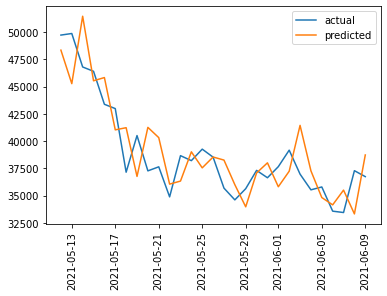

In [459]:
# plot the values for the predicted and the actual 1 day price
fig, ax = plt.subplots()

ax.plot(y_final_test.index, y_final_test['1_day'], label='actual')
ax.plot(y_final_test.index, y_final_test['new_pred'], label='predicted')
plt.legend()
plt.xticks(rotation='vertical')
plt.show()

### Find the mean squared error and the R-squared for the updated values

In [460]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_final_test['1_day'], y_final_test['new_pred'])

rmse = np.sqrt(mse)

rmse

2546.620560889827

In [461]:
from sklearn.metrics import r2_score

r2 = r2_score(y_final_test['1_day'], y_final_test['new_pred'])

r2

0.6632333944636379

## Best performance on the holdout set:

##### Using all 15 features for training and 2 degrees of polynomial

In [462]:
print('R2:', r2)
print('RMSE:', rmse)

R2: 0.6632333944636379
RMSE: 2546.620560889827


# ----------------------------------------------------------------------------------------------------

## Analysis of New Regression Model:
The higher R-squared value after using the price adjustment starting point is encouraging. Now, by adjusting the features which are used for the model, I will determine if a better combination exists. I will start by viewing the correlation between features and the one-day price to and begin with highest correlated features in combination

In [463]:
feat = btc_final.iloc[:, 9:]
btc_1_day = btc_final[['1_day']]

In [464]:
df_1_day = pd.concat([btc_final[['1_day']], btc_final.iloc[:, 9:]], axis=1)
df_1_day.head()


,1_day,ave_block_size,hash_rate,difficulty,block_height,transaction_rate,7dMA_transaction_rate,7dMA_transaction_rate_change,exchange_balance,exchange_withdrawals,...,sopr,rhodl,res_risk,puell,nvt,nupl,mvrv_ratio,mvrv_z,cvdd,cyd
0,13.034,89114.771605,2.351004e+13,1.279744e+16,214724,0.367292,0.449547,1.158979,2575.409335,43,...,0.998396,439.530560,0.003676,0.930871,7.582447,0.433613,1.760238,1.419095,2.378916,1.292381e+09
1,13.190,114158.385621,2.245758e+13,1.279744e+16,214877,0.454630,0.454256,1.047498,3184.319144,60,...,0.999711,448.670542,0.003656,0.876133,5.886555,0.427886,1.754977,1.367144,2.380707,1.292639e+09
2,13.174,108105.271605,2.370005e+13,1.279744e+16,215039,0.487812,0.451802,-0.540159,2830.291416,53,...,1.000494,457.846890,0.003648,0.927063,6.719452,0.428949,1.755247,1.405822,2.382824,1.293475e+09
3,13.150,141893.150327,2.217074e+13,1.279744e+16,215192,0.560602,0.454282,0.548948,2819.834982,72,...,1.002167,484.577915,0.003648,0.877796,4.761873,0.431352,1.758160,1.392039,2.388469,1.294278e+09
4,13.150,118321.985816,2.060638e+13,1.279744e+16,215333,0.456655,0.456744,0.541947,3527.843016,53,...,1.000162,479.252069,0.003624,0.806903,5.219117,0.428056,1.751028,1.389545,2.389654,1.293662e+09


In [465]:
# view the correlation between features
print('This is the correlation matrix for: ', df_1_day.columns[0], '\n')
corr = df_1_day.corr()
corr

This is the correlation matrix for:  1_day 



,1_day,ave_block_size,hash_rate,difficulty,block_height,transaction_rate,7dMA_transaction_rate,7dMA_transaction_rate_change,exchange_balance,exchange_withdrawals,...,sopr,rhodl,res_risk,puell,nvt,nupl,mvrv_ratio,mvrv_z,cvdd,cyd
1_day,1.000000,0.584664,0.782704,0.785226,0.648495,0.437059,0.450628,-0.043483,0.530525,0.692127,...,0.126536,0.050258,0.086678,0.166273,0.411586,0.325735,0.371654,0.414695,0.858248,0.420700
ave_block_size,0.584664,1.000000,0.714628,0.722117,0.936059,0.927158,0.931643,-0.014759,0.870209,0.863836,...,-0.004630,-0.138282,-0.263259,-0.166786,0.280069,0.136570,0.071127,0.118727,0.749903,0.534880
hash_rate,0.782704,0.714628,1.000000,0.990290,0.845067,0.611765,0.621665,-0.016218,0.793953,0.622043,...,0.025322,-0.141799,-0.170438,-0.091179,0.634569,0.170643,0.118301,0.125703,0.953099,0.344977
difficulty,0.785226,0.722117,0.990290,1.000000,0.845679,0.598102,0.614389,-0.047910,0.791889,0.623007,...,0.017028,-0.143303,-0.173710,-0.105670,0.624041,0.165657,0.113499,0.120941,0.960039,0.340556
block_height,0.648495,0.936059,0.845067,0.845679,1.000000,0.870703,0.890074,-0.040789,0.961387,0.824525,...,-0.063715,-0.162247,-0.289518,-0.222312,0.500643,0.062179,-0.009853,0.035474,0.869445,0.591310
transaction_rate,0.437059,0.927158,0.611765,0.598102,0.870703,1.000000,0.978235,0.080162,0.833180,0.823741,...,0.028748,-0.115666,-0.246991,-0.103869,0.198056,0.149697,0.084349,0.129030,0.617729,0.498836
7dMA_transaction_rate,0.450628,0.931643,0.621665,0.614389,0.890074,0.978235,1.000000,-0.016372,0.851765,0.819990,...,0.020607,-0.113303,-0.247779,-0.111425,0.254490,0.155494,0.087540,0.132841,0.633979,0.512410
7dMA_transaction_rate_change,-0.043483,-0.014759,-0.016218,-0.047910,-0.040789,0.080162,-0.016372,1.000000,-0.038984,-0.022514,...,0.082283,-0.022839,-0.018005,0.035665,-0.065481,-0.019962,0.010230,0.012471,-0.048018,-0.050115
exchange_balance,0.530525,0.870209,0.793953,0.791889,0.961387,0.833180,0.851765,-0.038984,1.000000,0.757133,...,-0.099845,-0.135400,-0.242925,-0.229987,0.535370,-0.009262,-0.084772,-0.041938,0.826787,0.653829
exchange_withdrawals,0.692127,0.863836,0.622043,0.623007,0.824525,0.823741,0.819990,-0.022514,0.757133,1.000000,...,0.098476,0.087107,0.033724,0.092907,0.168892,0.319785,0.300799,0.371331,0.708416,0.710898


Text(0.5, 0.98, 'Bitcoin On-Chain Data Correlation Heatmap for 1 Day Price')

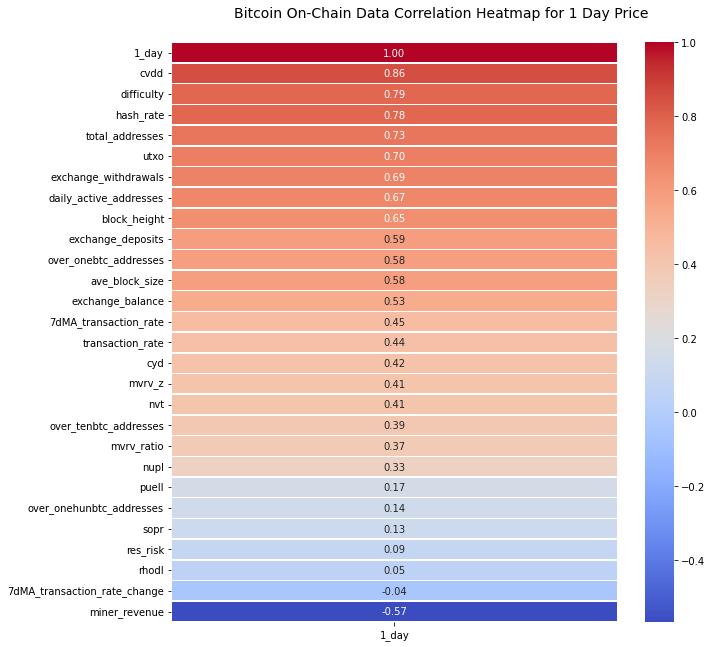

In [466]:
# create the correlation heatmap
f, ax = plt.subplots(figsize=(10, 10))
new_corr = corr.loc[:, ['1_day']].sort_values(by='1_day', ascending=False)
hm = sns.heatmap(new_corr, annot=True, ax=ax,
                cmap='coolwarm', fmt='.2f', linewidths=0.5)
f.subplots_adjust(top=0.93)
f.suptitle('Bitcoin On-Chain Data Correlation Heatmap for 1 Day Price', fontsize=14)

# Analyze the Feature Importances

In [467]:
scaler_feat = MinMaxScaler()
df_1_day.head()

# normalize the features
feat_1_day = pd.DataFrame(scaler_feat.fit_transform(df_1_day.iloc[:, 1:]),
              columns=df_1_day.columns[1:], index=df_1_day.index) 

In [468]:
feat_1_day.head()

,ave_block_size,hash_rate,difficulty,block_height,transaction_rate,7dMA_transaction_rate,7dMA_transaction_rate_change,exchange_balance,exchange_withdrawals,exchange_deposits,...,sopr,rhodl,res_risk,puell,nvt,nupl,mvrv_ratio,mvrv_z,cvdd,cyd
0,0.009112,2.867282e-08,4.336451e-10,0.000000,0.003398,0.008747,0.554756,0.000731,0.000075,0.000140,...,0.435539,0.001578,0.075423,0.063478,0.084617,0.756194,0.222687,0.158556,0.000000e+00,0.000487
1,0.026710,2.335443e-08,4.336451e-10,0.000324,0.019792,0.009843,0.550336,0.000930,0.000233,0.000246,...,0.438618,0.001619,0.074852,0.057929,0.065113,0.752750,0.221650,0.154628,1.875998e-07,0.000534
2,0.022457,2.963301e-08,4.336451e-10,0.000667,0.026021,0.009272,0.487377,0.000814,0.000168,0.000132,...,0.440453,0.001661,0.074626,0.063092,0.074692,0.753389,0.221703,0.157553,4.094905e-07,0.000688
3,0.046200,2.190495e-08,4.336451e-10,0.000991,0.039684,0.009849,0.530566,0.000811,0.000346,0.000776,...,0.444373,0.001783,0.074622,0.058097,0.052178,0.754834,0.222277,0.156511,1.000885e-06,0.000835
4,0.029636,1.399982e-08,4.336451e-10,0.001289,0.020172,0.010422,0.530288,0.001042,0.000168,0.000526,...,0.439676,0.001759,0.073960,0.050909,0.057437,0.752852,0.220871,0.156322,1.125036e-06,0.000722


In [469]:
target_1_day = df_1_day.iloc[: ,0]
target_1_day.head()

0    13.034
1    13.190
2    13.174
3    13.150
4    13.150
Name: 1_day, dtype: float64

In [470]:
# create train and test data
X_train, X_test, y_train, y_test = train_test_split(feat_1_day, target_1_day, test_size=0.3, random_state=5)

In [471]:
# import and use the Random Forest Regressor to get features importance
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, y_train)

# view the score of the training data
print(model.score(X_train, y_train))

0.9993853028467929


In [472]:
# view the score of the testing data
print(model.score(X_test, y_test))

0.9956394781703294


In [473]:
# get the importances
importances = model.feature_importances_

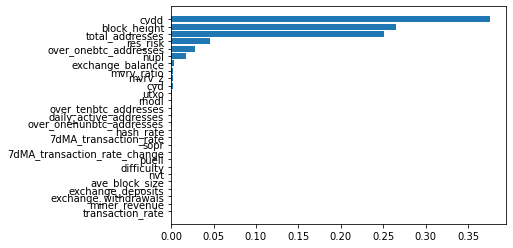

In [474]:
indices = np.argsort(importances)
fig, ax  = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

In [475]:
from sklearn.inspection import permutation_importance

permutation_results = permutation_importance(model, X_test, y_test)

In [476]:
def plot_importance_features(perm_importance_result, feat_name):
    """ bar plot the feature importance """

    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)

    indices = perm_importance_result['importances_mean'].argsort()
    plt.barh(range(len(indices)),
             perm_importance_result['importances_mean'][indices],
             xerr=perm_importance_result['importances_std'][indices])

    ax.set_yticks(range(len(indices)))
    _ = ax.set_yticklabels(feat_name[indices])


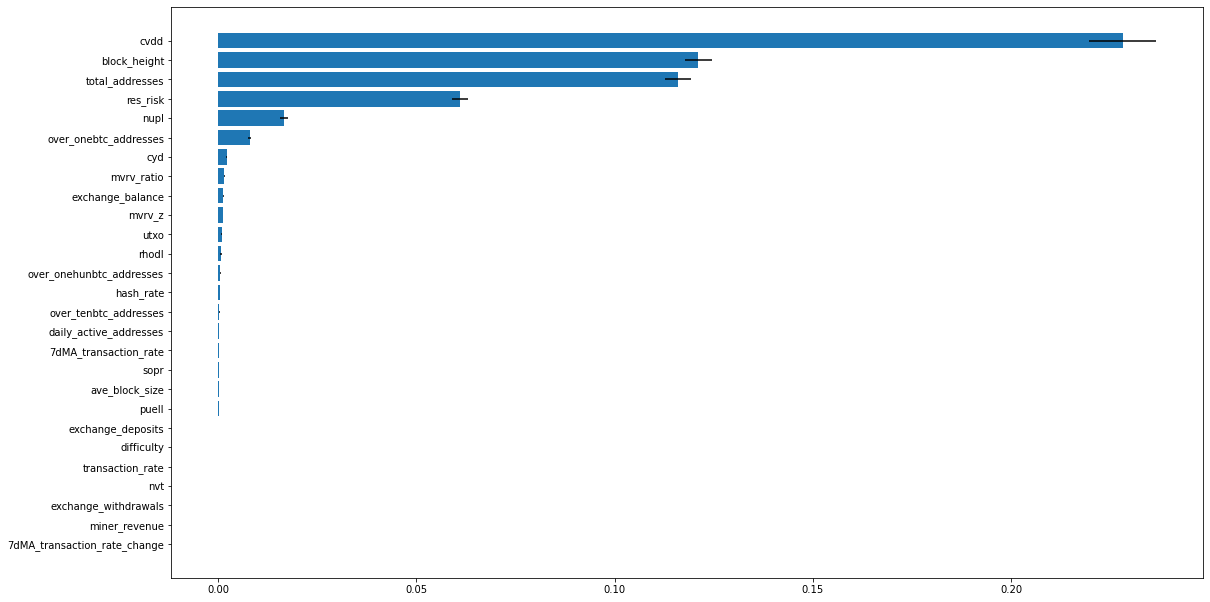

In [477]:
plot_importance_features(permutation_results, X_test.columns)

## Train and Test Model on the top 14 features

In [478]:
# find the top 14 features based on importances
importances_feat = permutation_results['importances_mean'].argsort()
indices = importances_feat[14:]
X_test.columns[indices]

Index(['over_onehunbtc_addresses', 'rhodl', 'utxo', 'mvrv_z',
       'exchange_balance', 'mvrv_ratio', 'cyd', 'over_onebtc_addresses',
       'nupl', 'res_risk', 'total_addresses', 'block_height', 'cvdd'],
      dtype='object')

Degree:  2
Train RMSE:  469.6129895077924
Train R2:  0.9979612766405238
Test RMSE:  553.7123794016645
Test R2:  0.9972698124781985 


Degree:  3
Train RMSE:  311.8872507593189
Train R2:  0.9991007647117957
Test RMSE:  767.1762742532458
Test R2:  0.9947589978515795 


Degree:  4
Train RMSE:  5.262687426130419
Train R2:  0.9999997439685891
Test RMSE:  246357.0304892852
Test R2:  -539.4480226684765 


Degree:  5
Train RMSE:  2.4483723355346835e-06
Train R2:  1.0
Test RMSE:  21731.949199050516
Test R2:  -3.20553617798517 


---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  469.6129895077924
Train R2:  0.9979612766405238
Test RMSE:  553.7123794016645
Test R2:  0.9972698124781985


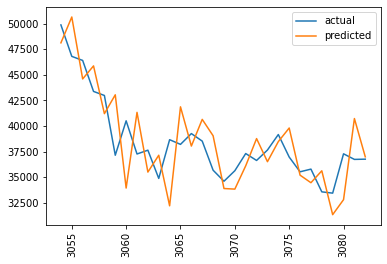

The results for Polynomial Regression using these features:
 Index(['over_onehunbtc_addresses', 'rhodl', 'utxo', 'mvrv_z',
       'exchange_balance', 'mvrv_ratio', 'cyd', 'over_onebtc_addresses',
       'nupl', 'res_risk', 'total_addresses', 'block_height', 'cvdd'],
      dtype='object')
30-day holdout RMSE: 3068.024808996882
30-day holdout: R2: 0.37869649548366946







0.37869649548366946

In [479]:
features = X_test.columns[indices]
matrix_poly_regression(btc_final,features , '1_day', print_out=True)

## Train and Test Model Removing One Feature at a Time

---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  469.6129895077924
Train R2:  0.9979612766405238
Test RMSE:  553.7123794016645
Test R2:  0.9972698124781985


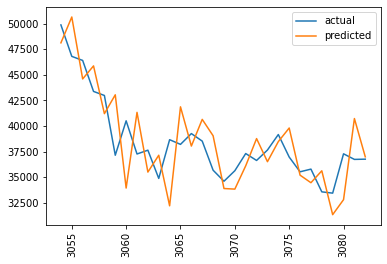

The results for Polynomial Regression using these features:
 Index(['over_onehunbtc_addresses', 'rhodl', 'utxo', 'mvrv_z',
       'exchange_balance', 'mvrv_ratio', 'cyd', 'over_onebtc_addresses',
       'nupl', 'res_risk', 'total_addresses', 'block_height', 'cvdd'],
      dtype='object')
30-day holdout RMSE: 3068.024808996882
30-day holdout: R2: 0.37869649548366946





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  472.9747201655926
Train R2:  0.9979319837124956
Test RMSE:  546.6493894769616
Test R2:  0.9973390191701343


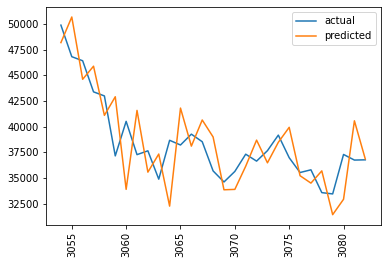

The results for Polynomial Regression using these features:
 Index(['rhodl', 'utxo', 'mvrv_z', 'exchange_balance', 'mvrv_ratio', 'cyd',
       'over_onebtc_addresses', 'nupl', 'res_risk', 'total_addresses',
       'block_height', 'cvdd'],
      dtype='object')
30-day holdout RMSE: 3056.4085307717487
30-day holdout: R2: 0.38339239706757355





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  482.2661505405789
Train R2:  0.9978499346600865
Test RMSE:  532.2583467957672
Test R2:  0.9974772804521305


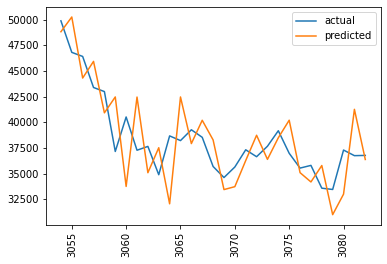

The results for Polynomial Regression using these features:
 Index(['utxo', 'mvrv_z', 'exchange_balance', 'mvrv_ratio', 'cyd',
       'over_onebtc_addresses', 'nupl', 'res_risk', 'total_addresses',
       'block_height', 'cvdd'],
      dtype='object')
30-day holdout RMSE: 3168.1001335631095
30-day holdout: R2: 0.3375030722326272





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  484.3184233362139
Train R2:  0.9978315966146224
Test RMSE:  535.8539322435852
Test R2:  0.9974430816784735


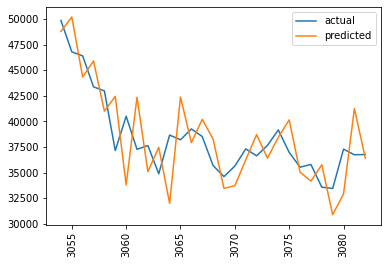

The results for Polynomial Regression using these features:
 Index(['mvrv_z', 'exchange_balance', 'mvrv_ratio', 'cyd',
       'over_onebtc_addresses', 'nupl', 'res_risk', 'total_addresses',
       'block_height', 'cvdd'],
      dtype='object')
30-day holdout RMSE: 3157.329290431095
30-day holdout: R2: 0.3420001022276312





---------------------------------------
Best Results are:
Degree:  3
Train RMSE:  424.46393174723426
Train R2:  0.9983344423015991
Test RMSE:  535.8088624984902
Test R2:  0.9974435117763183


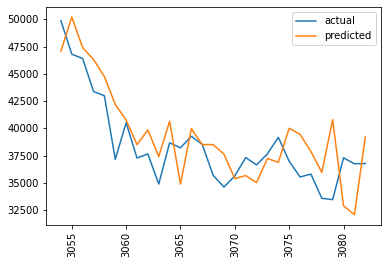

The results for Polynomial Regression using these features:
 Index(['exchange_balance', 'mvrv_ratio', 'cyd', 'over_onebtc_addresses',
       'nupl', 'res_risk', 'total_addresses', 'block_height', 'cvdd'],
      dtype='object')
30-day holdout RMSE: 2931.1263349273686
30-day holdout: R2: 0.432905880466505





---------------------------------------
Best Results are:
Degree:  3
Train RMSE:  429.79621518016353
Train R2:  0.9982923326673774
Test RMSE:  483.8327484223391
Test R2:  0.9979154393668028


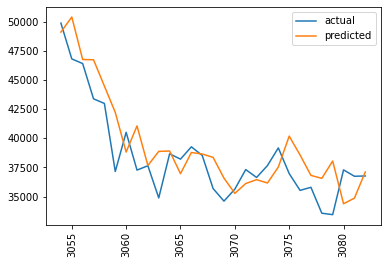

The results for Polynomial Regression using these features:
 Index(['mvrv_ratio', 'cyd', 'over_onebtc_addresses', 'nupl', 'res_risk',
       'total_addresses', 'block_height', 'cvdd'],
      dtype='object')
30-day holdout RMSE: 2406.219343973828
30-day holdout: R2: 0.6178300841534006





---------------------------------------
Best Results are:
Degree:  3
Train RMSE:  448.7488142414771
Train R2:  0.9981384070520831
Test RMSE:  493.4178805500168
Test R2:  0.9978320274553535


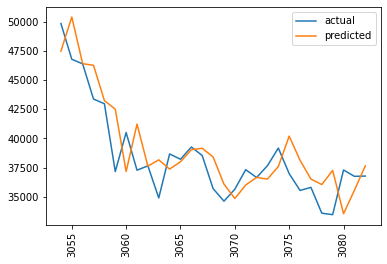

The results for Polynomial Regression using these features:
 Index(['cyd', 'over_onebtc_addresses', 'nupl', 'res_risk', 'total_addresses',
       'block_height', 'cvdd'],
      dtype='object')
30-day holdout RMSE: 2392.955415334221
30-day holdout: R2: 0.6220317819267454





---------------------------------------
Best Results are:
Degree:  3
Train RMSE:  466.61324036848276
Train R2:  0.9979872389808683
Test RMSE:  518.4552563414244
Test R2:  0.997606427564451


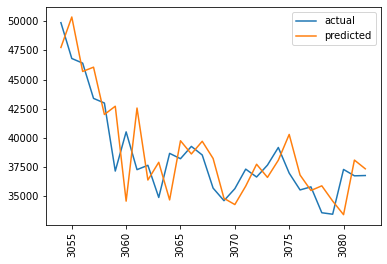

The results for Polynomial Regression using these features:
 Index(['over_onebtc_addresses', 'nupl', 'res_risk', 'total_addresses',
       'block_height', 'cvdd'],
      dtype='object')
30-day holdout RMSE: 2633.4490026690446
30-day holdout: R2: 0.5422420514533794





---------------------------------------
Best Results are:
Degree:  4
Train RMSE:  445.9922042773659
Train R2:  0.9981612078878435
Test RMSE:  520.63827374563
Test R2:  0.9975862282862873


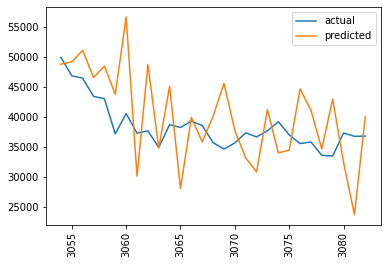

The results for Polynomial Regression using these features:
 Index(['nupl', 'res_risk', 'total_addresses', 'block_height', 'cvdd'], dtype='object')
30-day holdout RMSE: 6796.037986379122
30-day holdout: R2: -2.0485804792044715





---------------------------------------
Best Results are:
Degree:  4
Train RMSE:  533.4003049768168
Train R2:  0.9973698251760897
Test RMSE:  576.0856961542157
Test R2:  0.9970447229903945


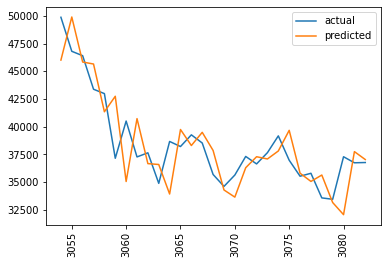

The results for Polynomial Regression using these features:
 Index(['res_risk', 'total_addresses', 'block_height', 'cvdd'], dtype='object')
30-day holdout RMSE: 2554.65840104022
30-day holdout: R2: 0.5692237598236516







In [480]:
while len(features) >= 4:
    matrix_poly_regression(btc_final, features, '1_day', print_out=False)
    features = features[1:]

## Use best performing model above and now add features one at a time

In [481]:
new_indices = importances_feat[:14] 
new_indices = np.flip(new_indices)
new_indices

array([ 1, 14, 12,  5, 17,  0, 20,  9,  2,  4, 21,  8, 10,  6],
      dtype=int64)

---------------------------------------
Best Results are:
Degree:  3
Train RMSE:  422.6331107887176
Train R2:  0.9983487792637247
Test RMSE:  502.17311883515487
Test R2:  0.9977544075796002


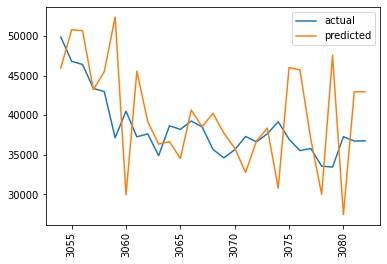

The results for Polynomial Regression using these features:
 ['cyd', 'over_onebtc_addresses', 'nupl', 'res_risk', 'total_addresses', 'block_height', 'cvdd', 'hash_rate']
30-day holdout RMSE: 6396.614353305146
30-day holdout: R2: -1.700762566546926





---------------------------------------
Best Results are:
Degree:  3
Train RMSE:  412.69187252882705
Train R2:  0.9984255461720384
Test RMSE:  501.5585549212584
Test R2:  0.9977599005681744


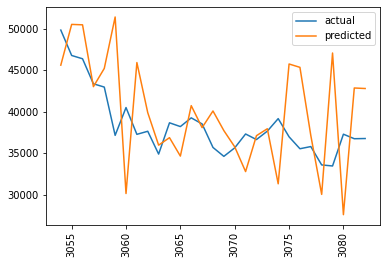

The results for Polynomial Regression using these features:
 ['cyd', 'over_onebtc_addresses', 'nupl', 'res_risk', 'total_addresses', 'block_height', 'cvdd', 'hash_rate', 'over_tenbtc_addresses']
30-day holdout RMSE: 6220.297160618578
30-day holdout: R2: -1.5539261461411091





---------------------------------------
Best Results are:
Degree:  3
Train RMSE:  391.42268162460766
Train R2:  0.9985836516761036
Test RMSE:  555.0170254364916
Test R2:  0.9972569316948552


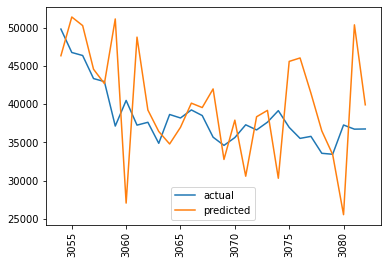

The results for Polynomial Regression using these features:
 ['cyd', 'over_onebtc_addresses', 'nupl', 'res_risk', 'total_addresses', 'block_height', 'cvdd', 'hash_rate', 'over_tenbtc_addresses', 'daily_active_addresses']
30-day holdout RMSE: 6765.121863081235
30-day holdout: R2: -2.0209067342020686





---------------------------------------
Best Results are:
Degree:  3
Train RMSE:  388.58763656072784
Train R2:  0.9986040943834428
Test RMSE:  555.4448905037115
Test R2:  0.997252700777813


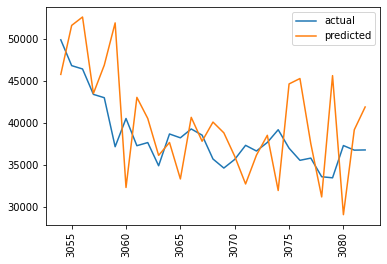

The results for Polynomial Regression using these features:
 ['cyd', 'over_onebtc_addresses', 'nupl', 'res_risk', 'total_addresses', 'block_height', 'cvdd', 'hash_rate', 'over_tenbtc_addresses', '7dMA_transaction_rate']
30-day holdout RMSE: 5780.58781272516
30-day holdout: R2: -1.2056168700430785





---------------------------------------
Best Results are:
Degree:  3
Train RMSE:  370.91879531068184
Train R2:  0.9987281503400045
Test RMSE:  604.1767593115236
Test R2:  0.996749485993226


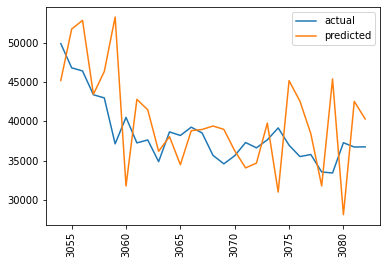

The results for Polynomial Regression using these features:
 ['cyd', 'over_onebtc_addresses', 'nupl', 'res_risk', 'total_addresses', 'block_height', 'cvdd', 'hash_rate', 'over_tenbtc_addresses', '7dMA_transaction_rate', 'sopr']
30-day holdout RMSE: 5909.403312147069
30-day holdout: R2: -1.3050127475302586





---------------------------------------
Best Results are:
Degree:  3
Train RMSE:  375.3199120256384
Train R2:  0.9986977891524192
Test RMSE:  564.262951992152
Test R2:  0.9971647779082338


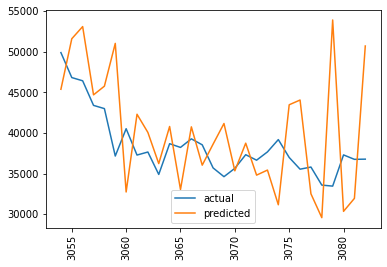

The results for Polynomial Regression using these features:
 ['cyd', 'over_onebtc_addresses', 'nupl', 'res_risk', 'total_addresses', 'block_height', 'cvdd', 'hash_rate', 'over_tenbtc_addresses', '7dMA_transaction_rate', 'ave_block_size']
30-day holdout RMSE: 6877.570581912777
30-day holdout: R2: -2.1221673745552585





---------------------------------------
Best Results are:
Degree:  3
Train RMSE:  358.47965640678166
Train R2:  0.9988120254787581
Test RMSE:  595.0870226600405
Test R2:  0.996846557110902


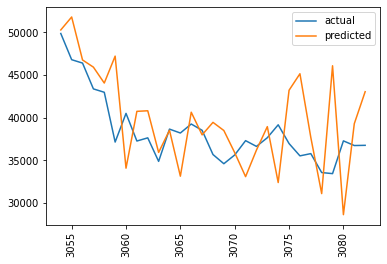

The results for Polynomial Regression using these features:
 ['cyd', 'over_onebtc_addresses', 'nupl', 'res_risk', 'total_addresses', 'block_height', 'cvdd', 'hash_rate', 'over_tenbtc_addresses', '7dMA_transaction_rate', 'puell']
30-day holdout RMSE: 5063.5503185908465
30-day holdout: R2: -0.6923739400128508





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  538.0332516411272
Train R2:  0.9973239370163313
Test RMSE:  595.6164408737689
Test R2:  0.9968409437042323


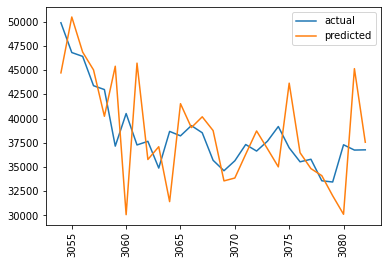

The results for Polynomial Regression using these features:
 ['cyd', 'over_onebtc_addresses', 'nupl', 'res_risk', 'total_addresses', 'block_height', 'cvdd', 'hash_rate', 'over_tenbtc_addresses', '7dMA_transaction_rate', 'puell', 'exchange_deposits']
30-day holdout RMSE: 4475.860456588938
30-day holdout: R2: -0.32232785124557606





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  530.1932475816784
Train R2:  0.9974013578300874
Test RMSE:  584.367289622875
Test R2:  0.9969591443329267


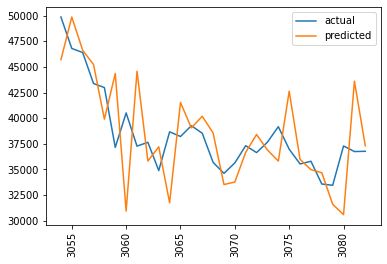

The results for Polynomial Regression using these features:
 ['cyd', 'over_onebtc_addresses', 'nupl', 'res_risk', 'total_addresses', 'block_height', 'cvdd', 'hash_rate', 'over_tenbtc_addresses', '7dMA_transaction_rate', 'puell', 'exchange_deposits', 'difficulty']
30-day holdout RMSE: 4006.1349669118463
30-day holdout: R2: -0.05934451495730908





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  523.3750321779697
Train R2:  0.9974677644692562
Test RMSE:  588.811945008241
Test R2:  0.9969127113619952


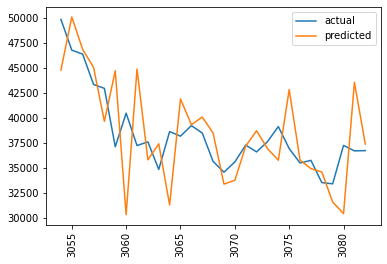

The results for Polynomial Regression using these features:
 ['cyd', 'over_onebtc_addresses', 'nupl', 'res_risk', 'total_addresses', 'block_height', 'cvdd', 'hash_rate', 'over_tenbtc_addresses', '7dMA_transaction_rate', 'puell', 'exchange_deposits', 'difficulty', 'transaction_rate']
30-day holdout RMSE: 4201.461528177815
30-day holdout: R2: -0.16516344616025735





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  522.1065589241914
Train R2:  0.997480024055173
Test RMSE:  601.8790947527898
Test R2:  0.9967741621804913


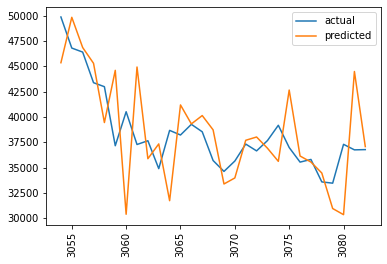

The results for Polynomial Regression using these features:
 ['cyd', 'over_onebtc_addresses', 'nupl', 'res_risk', 'total_addresses', 'block_height', 'cvdd', 'hash_rate', 'over_tenbtc_addresses', '7dMA_transaction_rate', 'puell', 'exchange_deposits', 'difficulty', 'nvt']
30-day holdout RMSE: 4187.370785975604
30-day holdout: R2: -0.15736116759941243





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  518.2497732481222
Train R2:  0.9975171165220411
Test RMSE:  591.6614388676516
Test R2:  0.9968827578371725


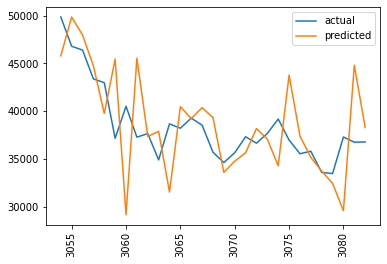

The results for Polynomial Regression using these features:
 ['cyd', 'over_onebtc_addresses', 'nupl', 'res_risk', 'total_addresses', 'block_height', 'cvdd', 'hash_rate', 'over_tenbtc_addresses', '7dMA_transaction_rate', 'puell', 'exchange_deposits', 'difficulty', 'exchange_withdrawals']
30-day holdout RMSE: 4546.030131746631
30-day holdout: R2: -0.3641140716837601





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  504.2146864061161
Train R2:  0.997649776958649
Test RMSE:  585.4568183264867
Test R2:  0.9969477946624012


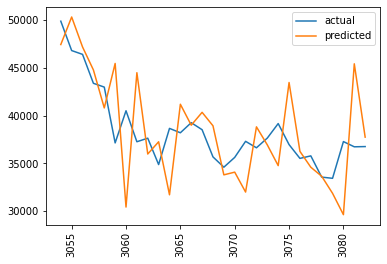

The results for Polynomial Regression using these features:
 ['cyd', 'over_onebtc_addresses', 'nupl', 'res_risk', 'total_addresses', 'block_height', 'cvdd', 'hash_rate', 'over_tenbtc_addresses', '7dMA_transaction_rate', 'puell', 'exchange_deposits', 'difficulty', 'miner_revenue']
30-day holdout RMSE: 4410.551658259901
30-day holdout: R2: -0.2840203158031078





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  526.2316922386184
Train R2:  0.9974400463815692
Test RMSE:  590.8941660379743
Test R2:  0.9968908375402536


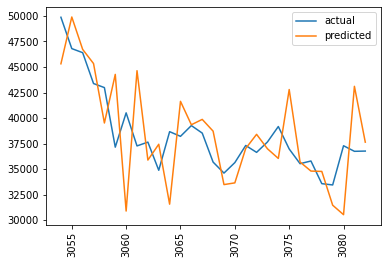

The results for Polynomial Regression using these features:
 ['cyd', 'over_onebtc_addresses', 'nupl', 'res_risk', 'total_addresses', 'block_height', 'cvdd', 'hash_rate', 'over_tenbtc_addresses', '7dMA_transaction_rate', 'puell', 'exchange_deposits', 'difficulty', '7dMA_transaction_rate_change']
30-day holdout RMSE: 4035.4532343640276
30-day holdout: R2: -0.07490654326834312







In [482]:
features = X_test.columns[indices]
new_indices = importances_feat[:14]          # take the features that haven't been used
new_indices = np.flip(new_indices)            # reverse the indices list to make the most influential add next
add_features = X_test.columns[new_indices]   # create a list of features to add to the best features
base_features = list(features[-7:])            # start with the best performing features

# iterate through the new features to add and test them in combination
for feat in add_features:
    base_features.append(feat)
    holdout_r2 = matrix_poly_regression(btc_final, base_features, '1_day', print_out=False)
    if feat == add_features[0]:
        best_r2 = holdout_r2
    elif holdout_r2 <= best_r2:
        base_features.pop()
    else:
        best_r2 = holdout_r2

## Best Model Features with Forward Feature Addition
Start with the features from the best performing polynomial regression model and add new features based on importance

In [483]:
# features from the r2 = 0.66 model
base_features = ['ave_block_size', 'hash_rate', 'difficulty', 'block_height',
       'transaction_rate', 'exchange_balance', 'exchange_withdrawals',
       'exchange_deposits', 'miner_revenue', 'total_addresses',
       'daily_active_addresses', 'over_onebtc_addresses',
       'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo']

In [484]:
features = X_test.columns[indices]
new_indices = importances_feat[:14]          # take the features that haven't been used
new_indices = np.flip(new_indices)            # reverse the indices list to make the most influential add next
ordered_features = X_test.columns[new_indices]   # create a list of features to add to the best features
add_features = [x for x in ordered_features if x not in base_features] # remove features that are in the base_features list

In [485]:
add_features

['7dMA_transaction_rate',
 'sopr',
 'puell',
 'nvt',
 '7dMA_transaction_rate_change']

---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  1060.8632696014731
Train R2:  0.9895960819391565
Test RMSE:  1169.1867007500664
Test R2:  0.9878271647435027


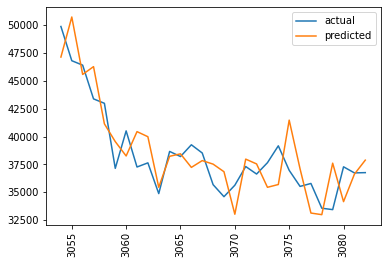

The results for Polynomial Regression using these features:
 ['ave_block_size', 'hash_rate', 'difficulty', 'block_height', 'transaction_rate', 'exchange_balance', 'exchange_withdrawals', 'exchange_deposits', 'miner_revenue', 'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses', 'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo']
30-day holdout RMSE: 2339.005589157894
30-day holdout: R2: 0.6388824558935536







0.6388824558935536

In [486]:
# test that the base features perform well
matrix_poly_regression(btc_final, base_features, '1_day', print_out=False)

---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  926.1430801121272
Train R2:  0.9920707105910997
Test RMSE:  1083.0790851602549
Test R2:  0.9895541364159717


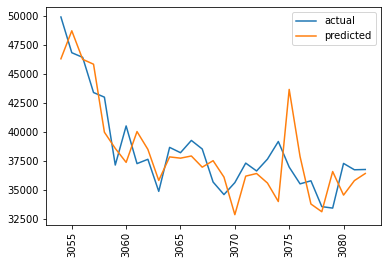

The results for Polynomial Regression using these features:
 ['ave_block_size', 'hash_rate', 'difficulty', 'block_height', 'transaction_rate', 'exchange_balance', 'exchange_withdrawals', 'exchange_deposits', 'miner_revenue', 'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses', 'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo', '7dMA_transaction_rate']
30-day holdout RMSE: 2459.6574462786025
30-day holdout: R2: 0.6006668864966872





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  952.7262184871729
Train R2:  0.9916089882181951
Test RMSE:  1035.3331592355369
Test R2:  0.9904548170169645


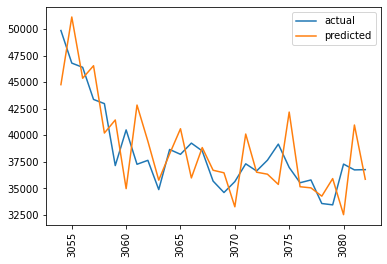

The results for Polynomial Regression using these features:
 ['ave_block_size', 'hash_rate', 'difficulty', 'block_height', 'transaction_rate', 'exchange_balance', 'exchange_withdrawals', 'exchange_deposits', 'miner_revenue', 'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses', 'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo', 'sopr']
30-day holdout RMSE: 3077.7626319111664
30-day holdout: R2: 0.374746237339489





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  644.6783664920681
Train R2:  0.9961579386918112
Test RMSE:  750.6135914588376
Test R2:  0.9949828526170391


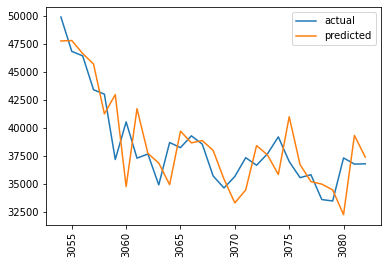

The results for Polynomial Regression using these features:
 ['ave_block_size', 'hash_rate', 'difficulty', 'block_height', 'transaction_rate', 'exchange_balance', 'exchange_withdrawals', 'exchange_deposits', 'miner_revenue', 'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses', 'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo', 'puell']
30-day holdout RMSE: 2678.375494361292
30-day holdout: R2: 0.526490175161217





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  1047.0435997435932
Train R2:  0.9898653762536176
Test RMSE:  1159.3937934708638
Test R2:  0.9880302259250067


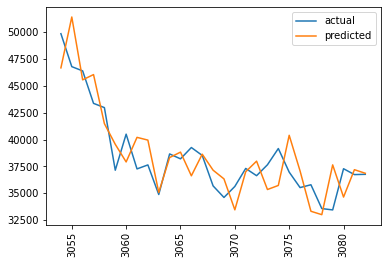

The results for Polynomial Regression using these features:
 ['ave_block_size', 'hash_rate', 'difficulty', 'block_height', 'transaction_rate', 'exchange_balance', 'exchange_withdrawals', 'exchange_deposits', 'miner_revenue', 'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses', 'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo', '7dMA_transaction_rate_change']
30-day holdout RMSE: 2274.845730113848
30-day holdout: R2: 0.6584219387625891





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  959.8036707523977
Train R2:  0.9914838576902231
Test RMSE:  1195.3370573751904
Test R2:  0.9872765532038905


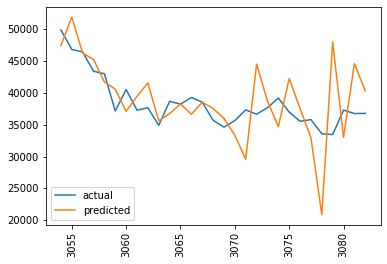

The results for Polynomial Regression using these features:
 ['ave_block_size', 'hash_rate', 'difficulty', 'block_height', 'transaction_rate', 'exchange_balance', 'exchange_withdrawals', 'exchange_deposits', 'miner_revenue', 'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses', 'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo', '7dMA_transaction_rate_change', 'nvt']
30-day holdout RMSE: 5083.885596878559
30-day holdout: R2: -0.7059944229472321







In [240]:
best_r2 = 0.63888  # assign the best value to compare with
base_feat_new = base_features

# iterate through the new features to add and test them in combination
for feat in add_features:
    base_feat_new.append(feat)
    holdout_r2 = matrix_poly_regression(btc_final, base_feat_new, '1_day', print_out=False)
    if holdout_r2 <= best_r2:
        base_feat_new.pop()
    else:
        best_r2 = holdout_r2

**The best performing set of features using this feature addition and importance is:**

'ave_block_size', 'hash_rate', 'difficulty', 'block_height', 'transaction_rate', 'exchange_balance', 'exchange_withdrawals', 'exchange_deposits', 'miner_revenue', 'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses', 'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo', '7dMA_transaction_rate_change'

**And the statistics are:**

    30-day holdout R2: 0.658
    30-day holdout RMSE: 2274.85


In [241]:
print(base_feat_new)

['ave_block_size', 'hash_rate', 'difficulty', 'block_height', 'transaction_rate', 'exchange_balance', 'exchange_withdrawals', 'exchange_deposits', 'miner_revenue', 'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses', 'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo', '7dMA_transaction_rate_change']


In [487]:
btc_final.columns[9:]

Index(['ave_block_size', 'hash_rate', 'difficulty', 'block_height',
       'transaction_rate', '7dMA_transaction_rate',
       '7dMA_transaction_rate_change', 'exchange_balance',
       'exchange_withdrawals', 'exchange_deposits', 'miner_revenue',
       'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses',
       'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo', 'sopr',
       'rhodl', 'res_risk', 'puell', 'nvt', 'nupl', 'mvrv_ratio', 'mvrv_z',
       'cvdd', 'cyd'],
      dtype='object')

### Try feature addition without using importance to influence the addition order

In [488]:
add_features = [x for x in btc_final.columns[9:] if x not in base_features]

In [489]:
add_features

['7dMA_transaction_rate',
 '7dMA_transaction_rate_change',
 'sopr',
 'rhodl',
 'res_risk',
 'puell',
 'nvt',
 'nupl',
 'mvrv_ratio',
 'mvrv_z',
 'cvdd',
 'cyd']

---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  926.1430801121272
Train R2:  0.9920707105910997
Test RMSE:  1083.0790851602549
Test R2:  0.9895541364159717


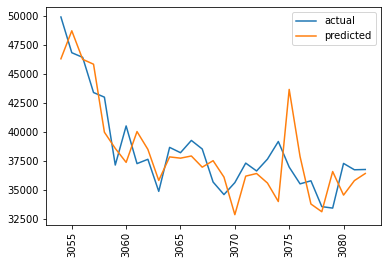

The results for Polynomial Regression using these features:
 ['ave_block_size', 'hash_rate', 'difficulty', 'block_height', 'transaction_rate', 'exchange_balance', 'exchange_withdrawals', 'exchange_deposits', 'miner_revenue', 'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses', 'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo', '7dMA_transaction_rate']
30-day holdout RMSE: 2459.6574462786025
30-day holdout: R2: 0.6006668864966872





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  1047.0435997435932
Train R2:  0.9898653762536176
Test RMSE:  1159.3937934708638
Test R2:  0.9880302259250067


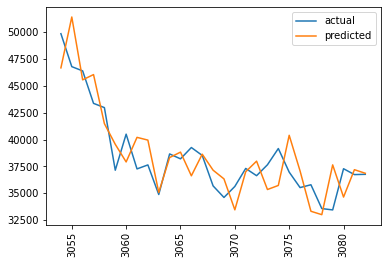

The results for Polynomial Regression using these features:
 ['ave_block_size', 'hash_rate', 'difficulty', 'block_height', 'transaction_rate', 'exchange_balance', 'exchange_withdrawals', 'exchange_deposits', 'miner_revenue', 'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses', 'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo', '7dMA_transaction_rate_change']
30-day holdout RMSE: 2274.845730113848
30-day holdout: R2: 0.6584219387625891





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  932.9592569834342
Train R2:  0.9919535659988147
Test RMSE:  1008.0087928959315
Test R2:  0.9909519987478969


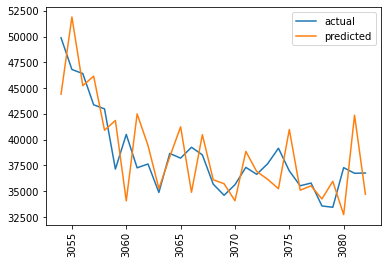

The results for Polynomial Regression using these features:
 ['ave_block_size', 'hash_rate', 'difficulty', 'block_height', 'transaction_rate', 'exchange_balance', 'exchange_withdrawals', 'exchange_deposits', 'miner_revenue', 'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses', 'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo', '7dMA_transaction_rate_change', 'sopr']
30-day holdout RMSE: 3213.0062934407833
30-day holdout: R2: 0.3185888723056227





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  905.0802440725049
Train R2:  0.9924272735749233
Test RMSE:  978.0742430952414
Test R2:  0.9914814111902219


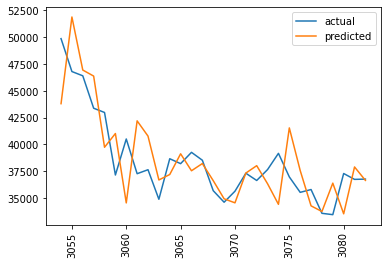

The results for Polynomial Regression using these features:
 ['ave_block_size', 'hash_rate', 'difficulty', 'block_height', 'transaction_rate', 'exchange_balance', 'exchange_withdrawals', 'exchange_deposits', 'miner_revenue', 'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses', 'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo', '7dMA_transaction_rate_change', 'rhodl']
30-day holdout RMSE: 2973.9105295408767
30-day holdout: R2: 0.4162298744433581





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  548.979269281882
Train R2:  0.9972139430691012
Test RMSE:  642.9043046230944
Test R2:  0.996319416470872


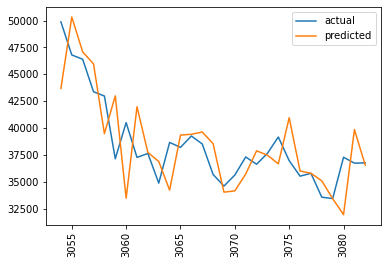

The results for Polynomial Regression using these features:
 ['ave_block_size', 'hash_rate', 'difficulty', 'block_height', 'transaction_rate', 'exchange_balance', 'exchange_withdrawals', 'exchange_deposits', 'miner_revenue', 'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses', 'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo', '7dMA_transaction_rate_change', 'res_risk']
30-day holdout RMSE: 3106.6801411687657
30-day holdout: R2: 0.36294173921493256





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  636.7371868030028
Train R2:  0.9962520091178997
Test RMSE:  747.9949563831749
Test R2:  0.9950177977902332


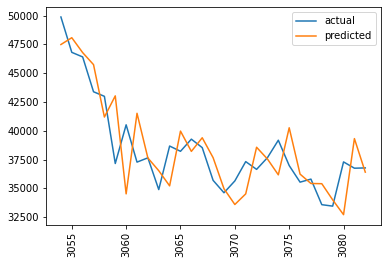

The results for Polynomial Regression using these features:
 ['ave_block_size', 'hash_rate', 'difficulty', 'block_height', 'transaction_rate', 'exchange_balance', 'exchange_withdrawals', 'exchange_deposits', 'miner_revenue', 'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses', 'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo', '7dMA_transaction_rate_change', 'puell']
30-day holdout RMSE: 2598.0774983102865
30-day holdout: R2: 0.5544563358968728





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  959.8036707523977
Train R2:  0.9914838576902231
Test RMSE:  1195.3370573751904
Test R2:  0.9872765532038905


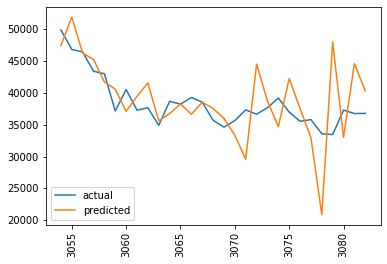

The results for Polynomial Regression using these features:
 ['ave_block_size', 'hash_rate', 'difficulty', 'block_height', 'transaction_rate', 'exchange_balance', 'exchange_withdrawals', 'exchange_deposits', 'miner_revenue', 'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses', 'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo', '7dMA_transaction_rate_change', 'nvt']
30-day holdout RMSE: 5083.885596878559
30-day holdout: R2: -0.7059944229472321





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  706.3084986242436
Train R2:  0.9953882372102312
Test RMSE:  842.7799485316652
Test R2:  0.9936751184061249


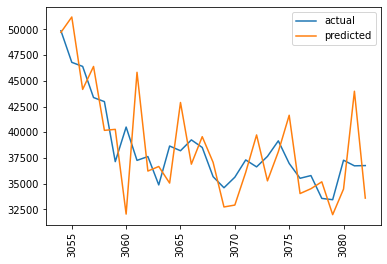

The results for Polynomial Regression using these features:
 ['ave_block_size', 'hash_rate', 'difficulty', 'block_height', 'transaction_rate', 'exchange_balance', 'exchange_withdrawals', 'exchange_deposits', 'miner_revenue', 'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses', 'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo', '7dMA_transaction_rate_change', 'nupl']
30-day holdout RMSE: 3593.0331828639164
30-day holdout: R2: 0.14786476138973215





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  590.3750015885998
Train R2:  0.9967779370834112
Test RMSE:  701.9218059878835
Test R2:  0.9956126580977395


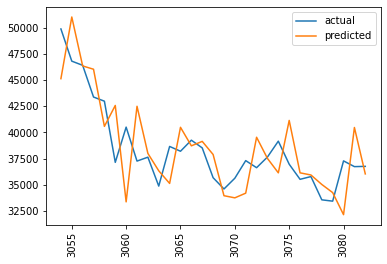

The results for Polynomial Regression using these features:
 ['ave_block_size', 'hash_rate', 'difficulty', 'block_height', 'transaction_rate', 'exchange_balance', 'exchange_withdrawals', 'exchange_deposits', 'miner_revenue', 'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses', 'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo', '7dMA_transaction_rate_change', 'mvrv_ratio']
30-day holdout RMSE: 3099.1000690354294
30-day holdout: R2: 0.3660466976988658





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  573.6730687740549
Train R2:  0.9969576650846949
Test RMSE:  713.8247085050184
Test R2:  0.9954625989799285


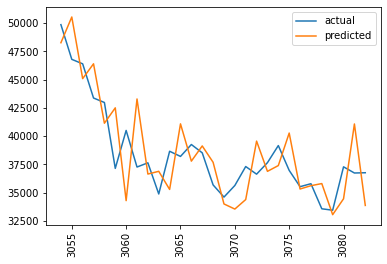

The results for Polynomial Regression using these features:
 ['ave_block_size', 'hash_rate', 'difficulty', 'block_height', 'transaction_rate', 'exchange_balance', 'exchange_withdrawals', 'exchange_deposits', 'miner_revenue', 'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses', 'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo', '7dMA_transaction_rate_change', 'mvrv_z']
30-day holdout RMSE: 2892.426258318539
30-day holdout: R2: 0.44778187108351153





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  849.5534450130865
Train R2:  0.9933279466896267
Test RMSE:  1028.7105988615185
Test R2:  0.9905765389490865


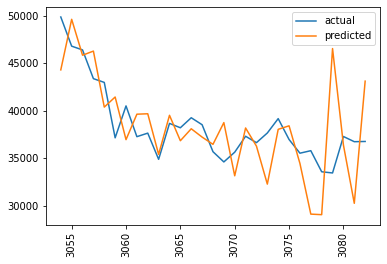

The results for Polynomial Regression using these features:
 ['ave_block_size', 'hash_rate', 'difficulty', 'block_height', 'transaction_rate', 'exchange_balance', 'exchange_withdrawals', 'exchange_deposits', 'miner_revenue', 'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses', 'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo', '7dMA_transaction_rate_change', 'cvdd']
30-day holdout RMSE: 4065.4447703323294
30-day holdout: R2: -0.09094335169542167





---------------------------------------
Best Results are:
Degree:  2
Train RMSE:  1009.1288837528687
Train R2:  0.990586061194197
Test RMSE:  1144.0214805455623
Test R2:  0.9883455342735803


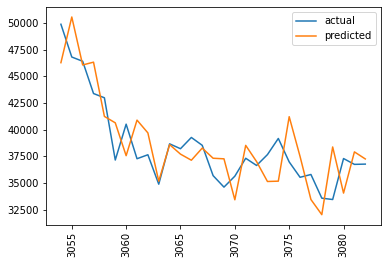

The results for Polynomial Regression using these features:
 ['ave_block_size', 'hash_rate', 'difficulty', 'block_height', 'transaction_rate', 'exchange_balance', 'exchange_withdrawals', 'exchange_deposits', 'miner_revenue', 'total_addresses', 'daily_active_addresses', 'over_onebtc_addresses', 'over_tenbtc_addresses', 'over_onehunbtc_addresses', 'utxo', '7dMA_transaction_rate_change', 'cyd']
30-day holdout RMSE: 2535.7600394997485
30-day holdout: R2: 0.5755736133242404







In [490]:
best_r2 = 0.63888  # assign the best value to compare with

base_feat_new = base_features

# iterate through the new features to add and test them in combination
for feat in add_features:
    base_feat_new.append(feat)
    holdout_r2 = matrix_poly_regression(btc_final, base_feat_new, '1_day', print_out=False)
    if holdout_r2 <= best_r2:
        base_feat_new.pop()
    else:
        best_r2 = holdout_r2

## Analysis of Feature Selection with the Polynomial Regression Model


The best regression performance resulted in a **30-day holdout R-squared of 0.658** which is not significant enough to continue exploring this model any further.